## Pupillometry analysis using pupil_labs data in screen stimulation


The idea of this code is to segement temporal windows to analyse how each stimuly might affect pupil size.
The idea is to generate common functions that can serve as an approximation for other analysis, that is:
1) Segment signal by annotations
2) Segmente signal by temporal cues
3) Do mean of signal

Lets start by opennig some data

In [2]:
import pandas as pd 
import numpy as np
from pathlib import Path
import os
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import signal
import commons as cm
from data_curation import Normalization
nm=Normalization()


recording_location = r"C:\Users\Bolo\Desktop\Laboratorio\incipit\data\pupil_emotibit\ES0001_S002_PC_EM\data\pupil_labs\002"
image_location=r"../../../../data/pupil_emotibit/ES0001_S002_PC_EM/images_order"

def print_file_structure(startpath):
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print(f'{indent}{os.path.basename(root)}/')
        subindent = ' ' * 4 * (level + 1)
        for f in sorted(files):
            print(f'{subindent}{f}')
print_file_structure(recording_location)


exported_pupil_csv = os.path.join(recording_location, 'exports', '000', 'pupil_positions.csv')
pupil_pd_frame = pd.read_csv(exported_pupil_csv)
exported_gaze_csv = os.path.join(recording_location, 'exports', '000', 'gaze_positions.csv')
gaze_pd_frame = pd.read_csv(exported_gaze_csv)
annotations_csv = os.path.join(recording_location, 'exports', '000', 'annotations.csv')
annotations_pd = pd.read_csv(annotations_csv)

002/
    annotation.pldata
    annotation_timestamps.npy
    blinks.pldata
    blinks_timestamps.npy
    eye0.intrinsics
    eye0.mp4
    eye0_lookup.npy
    eye0_timestamps.npy
    eye1.intrinsics
    eye1.mp4
    eye1_lookup.npy
    eye1_timestamps.npy
    fixations.pldata
    fixations_timestamps.npy
    gaze.pldata
    gaze_timestamps.npy
    info.player.json
    notify.pldata
    notify_timestamps.npy
    pupil.pldata
    pupil_timestamps.npy
    square_marker_cache
    surface_definitions_v01
    user_info.csv
    world.intrinsics
    world.mp4
    world_lookup.npy
    world_timestamps.npy
    exports/
        000/
            annotations.csv
            blink_detection_report.csv
            blinks.csv
            export_info.csv
            fixation_report.csv
            fixations.csv
            gaze_positions.csv
            pupil_gaze_positions_info.txt
            pupil_positions.csv
            world.mp4
            world_timestamps.csv
            world_timestamps.npy
  

In [3]:
pupil_pd_frame.head()

,pupil_timestamp,world_index,eye_id,confidence,norm_pos_x,norm_pos_y,diameter,method,ellipse_center_x,ellipse_center_y,...,circle_3d_normal_y,circle_3d_normal_z,circle_3d_radius,theta,phi,projected_sphere_center_x,projected_sphere_center_y,projected_sphere_axis_a,projected_sphere_axis_b,projected_sphere_angle
0,14963.532079,0,0,0.967541,0.384912,0.601413,32.496613,pye3d 0.3.0 real-time,73.903172,76.528654,...,0.018373,-0.853685,1.690155,1.552422,-2.118296,114.033851,78.141415,165.699953,165.699953,0.0
1,14963.532079,0,0,0.967541,0.384946,0.601443,32.499603,2d c++,73.909576,76.522873,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,14963.532146,0,1,1.000000,0.305218,0.387613,36.263992,2d c++,58.601776,117.578255,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,14963.532146,0,1,1.000000,0.305221,0.387696,36.252590,pye3d 0.3.0 real-time,58.602380,117.562393,...,-0.166674,-0.782323,1.777172,1.738252,-2.225184,109.252397,126.930874,174.366655,174.366655,0.0
4,14963.540161,1,0,0.968023,0.385050,0.601268,32.357941,pye3d 0.3.0 real-time,73.929623,76.556600,...,0.016104,-0.854217,1.682928,1.554692,-2.117337,114.033851,78.141415,165.699953,165.699953,0.0


In [4]:
pupil_pd_frame.columns

Index(['pupil_timestamp', 'world_index', 'eye_id', 'confidence', 'norm_pos_x',
       'norm_pos_y', 'diameter', 'method', 'ellipse_center_x',
       'ellipse_center_y', 'ellipse_axis_a', 'ellipse_axis_b', 'ellipse_angle',
       'diameter_3d', 'model_confidence', 'model_id', 'sphere_center_x',
       'sphere_center_y', 'sphere_center_z', 'sphere_radius',
       'circle_3d_center_x', 'circle_3d_center_y', 'circle_3d_center_z',
       'circle_3d_normal_x', 'circle_3d_normal_y', 'circle_3d_normal_z',
       'circle_3d_radius', 'theta', 'phi', 'projected_sphere_center_x',
       'projected_sphere_center_y', 'projected_sphere_axis_a',
       'projected_sphere_axis_b', 'projected_sphere_angle'],
      dtype='object')

In [5]:
from IPython.display import display

confidence_thr=0.99

# filter for 3d data
detector_3d_data = pupil_pd_frame[pupil_pd_frame.method == 'pye3d 0.3.0 real-time']

# skip first 5 seconds to allow for the 3D model to converge
# pupil_left_eye=detector_3d_data.loc[(pupil_pd_frame['eye_id']==1) & (pupil_pd_frame['confidence']>0.99), ['diameter','pupil_timestamp']]
# pupil_right_eye=detector_3d_data.loc[(pupil_pd_frame['eye_id']==0) & (pupil_pd_frame['confidence']>0.99), ['diameter','pupil_timestamp']]

pupil_left_eye=detector_3d_data.loc[(pupil_pd_frame['eye_id']==1) & (pupil_pd_frame['confidence']>confidence_thr)]
pupil_right_eye=detector_3d_data.loc[(pupil_pd_frame['eye_id']==0) & (pupil_pd_frame['confidence']>confidence_thr)]

filter_events=annotations_pd['label'].str.contains('Asset') | annotations_pd['label'].str.contains('Control') | annotations_pd['label'].str.contains('Surprise')
filter_assets=annotations_pd['label'].str.contains('Asset') 

filter_events_surprise= annotations_pd['label'].str.contains('Surprise')
filter_events_blank= annotations_pd['label'].str.contains('blank')


# pd.options.display.float_format = '{:.3f}'.format

print("eye0 (right eye) data:")
display(pupil_right_eye[['pupil_timestamp', 'eye_id', 'confidence', 'norm_pos_x', 'norm_pos_y', 'diameter_3d']].head(10))

print("eye1 data (left eye) data:")
display(pupil_left_eye[['pupil_timestamp', 'eye_id', 'confidence', 'norm_pos_x', 'norm_pos_y', 'diameter_3d']].head(10))

eye0 (right eye) data:


,pupil_timestamp,eye_id,confidence,norm_pos_x,norm_pos_y,diameter_3d
40,14963.612106,0,1.000000,0.386152,0.600647,3.433041
44,14963.620093,0,0.997117,0.386382,0.600804,3.440457
93,14963.716120,0,0.994328,0.386449,0.601041,3.449854
101,14963.732101,0,1.000000,0.386593,0.601129,3.430699
126,14963.784066,0,1.000000,0.360289,0.558968,3.279102
128,14963.792129,0,1.000000,0.354970,0.554910,3.280315
135,14963.800065,0,1.000000,0.353633,0.556613,3.292825
136,14963.808131,0,1.000000,0.354417,0.557709,3.268855
141,14963.816080,0,1.000000,0.353835,0.556312,3.236991
145,14963.824134,0,1.000000,0.353366,0.555723,3.235702


eye1 data (left eye) data:


,pupil_timestamp,eye_id,confidence,norm_pos_x,norm_pos_y,diameter_3d
3,14963.532146,1,1.0,0.305221,0.387696,3.554344
7,14963.540213,1,1.0,0.306098,0.388176,3.572560
11,14963.548129,1,1.0,0.306152,0.388124,3.577553
14,14963.556179,1,1.0,0.306005,0.388571,3.586922
17,14963.564011,1,1.0,0.306584,0.388046,3.616857
21,14963.572084,1,1.0,0.306660,0.388568,3.620500
25,14963.579989,1,1.0,0.306887,0.388388,3.616409
28,14963.588009,1,1.0,0.306617,0.388647,3.622452
33,14963.596015,1,1.0,0.306783,0.388604,3.619133
36,14963.604024,1,1.0,0.306974,0.388281,3.624435


In [6]:
%matplotlib qt
sns.set_theme()
fig, ax=plt.subplots(1,1)
ax.plot(pupil_left_eye['pupil_timestamp'],pupil_left_eye['diameter'])
for  index, row in annotations_pd[filter_events].iterrows():
    plt.axvline(row['timestamp'], color='r', label='axvline - full height')
    ax.text((row['timestamp']),30,row['label'])
ax.set_title('pupil diameter and events')    

fig, ax=plt.subplots(1,1)
ax.plot(pupil_left_eye['pupil_timestamp'],pupil_left_eye['diameter'])
for  index, row in annotations_pd[filter_events_surprise].iterrows():
    plt.axvline(row['timestamp'], color='r', label='axvline - full height')
    ax.text((row['timestamp']),30,row['label'])
ax.set_title('pupil diameter and events')    
plt.tight_layout()

In [7]:
%matplotlib qt
sns.set_theme()
fig, ax=plt.subplots(1,1)
ax.plot(pupil_left_eye['pupil_timestamp'],pupil_left_eye['diameter_3d'])
for  index, row in annotations_pd[filter_events].iterrows():
    plt.axvline(row['timestamp'], color='r', label='axvline - full height')
    ax.text((row['timestamp']),4,row['label'])
ax.set_title('pupil diameter and events')    

fig, ax=plt.subplots(1,1)
ax.plot(pupil_left_eye['pupil_timestamp'],pupil_left_eye['diameter_3d'])
for  index, row in annotations_pd[filter_events_surprise].iterrows():
    plt.axvline(row['timestamp'], color='r', label='axvline - full height')
    ax.text((row['timestamp']),4,row['label'])
ax.set_title('pupil diameter and events')    
plt.tight_layout()

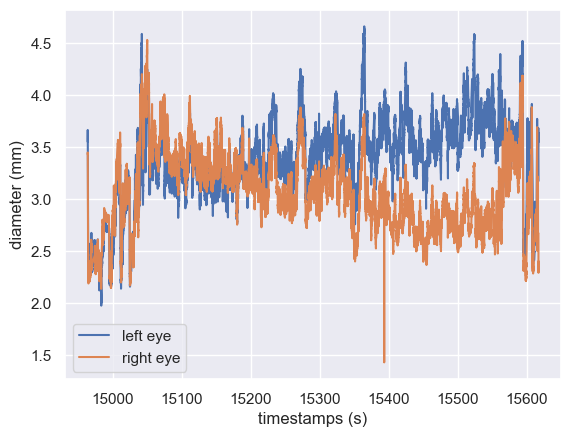

In [8]:
%matplotlib inline

cm.plot_pupillometry_both_eyes(
                                df_left_eye=pupil_left_eye,
                                df_right_eye=pupil_right_eye
)

### Lets do some temporal window filtering


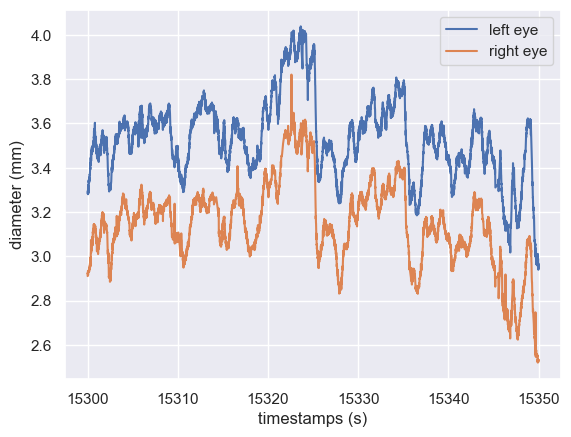

In [9]:
left_window=cm.filter_rows_by_temporal_values(
                                            dataframe= pupil_left_eye,
                                            ini_value=15300,
                                            end_value=15350,
                                            time_column='pupil_timestamp')

right_window=cm.filter_rows_by_temporal_values(
                                            dataframe= pupil_right_eye,
                                            ini_value=15300,
                                            end_value=15350,
                                            time_column='pupil_timestamp')



cm.plot_pupillometry_both_eyes(
                                df_left_eye=left_window,
                                df_right_eye=right_window
)

Lets normalize the data in std deviations


C:\Users\Bolo\AppData\Local\Temp\ipykernel_21324\3469484839.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pupil_left_eye['diameter_3d']=nm.normalize(values=pupil_left_eye['diameter_3d'],
C:\Users\Bolo\AppData\Local\Temp\ipykernel_21324\3469484839.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pupil_right_eye['diameter_3d']=nm.normalize(values=pupil_right_eye['diameter_3d'],


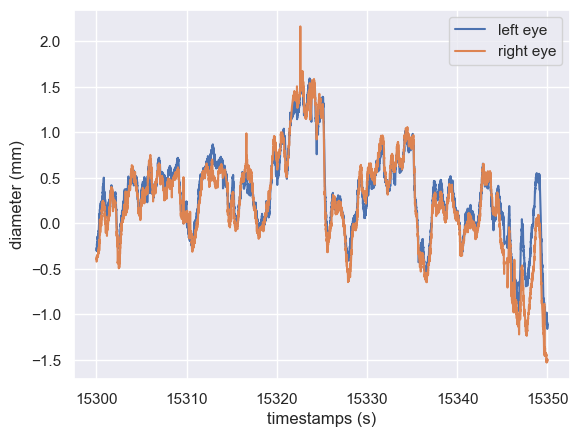

In [10]:
pupil_left_eye['diameter_3d']=nm.normalize(values=pupil_left_eye['diameter_3d'],
                                            type='z_score'
                                            )
pupil_right_eye['diameter_3d']=nm.normalize(values=pupil_right_eye['diameter_3d'],
                                            type='z_score'
                                            )       
left_window=cm.filter_rows_by_temporal_values(
                                            dataframe= pupil_left_eye,
                                            ini_value=15300,
                                            end_value=15350,
                                            time_column='pupil_timestamp')

right_window=cm.filter_rows_by_temporal_values(
                                            dataframe= pupil_right_eye,
                                            ini_value=15300,
                                            end_value=15350,
                                            time_column='pupil_timestamp')
cm.plot_pupillometry_both_eyes(
                                df_left_eye=left_window,
                                df_right_eye=right_window
                                )

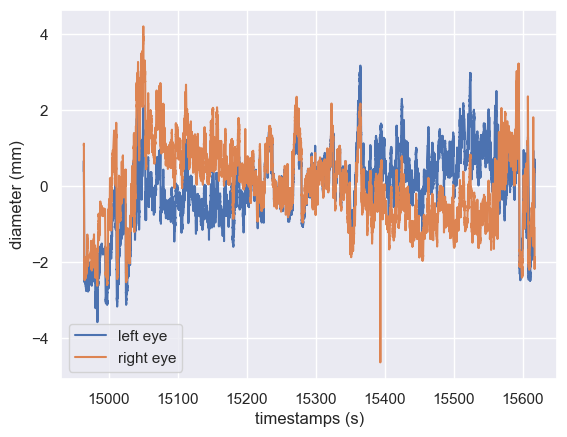

In [11]:
cm.plot_pupillometry_both_eyes(
                                df_left_eye=pupil_left_eye,
                                df_right_eye=pupil_right_eye
                                )

Now the idea is to select the temporal window of each asset and perform the mean

In [12]:
#Lets extract a list with the annotations
images=[]
with open(image_location+'/assets.txt','r') as f:
    for image in f:
        images.append(image.replace('\n',''))
    f.close()


## Lets see the mean pupillometry of all events

In [13]:

pupil_matrix=np.zeros([pupil_left_eye.shape[0],len(images)])


for num,im in enumerate(images):
    initial_anotation,end_anotation=cm.extract_annotations_timestamps(im,'label',annotations_pd)

    segmented_df=cm.filter_rows_by_temporal_values(
        dataframe=pupil_left_eye,
        time_column='pupil_timestamp',
        ini_value=initial_anotation['timestamp'].values[0],
        end_value=end_anotation['timestamp'].values[0]
        )

    pupil_matrix[0:len(segmented_df),num]=segmented_df['diameter_3d']

ValueError: too many values to unpack (expected 2)

Text(0.5, 1.0, 'Raw assets and mean pupilometry')

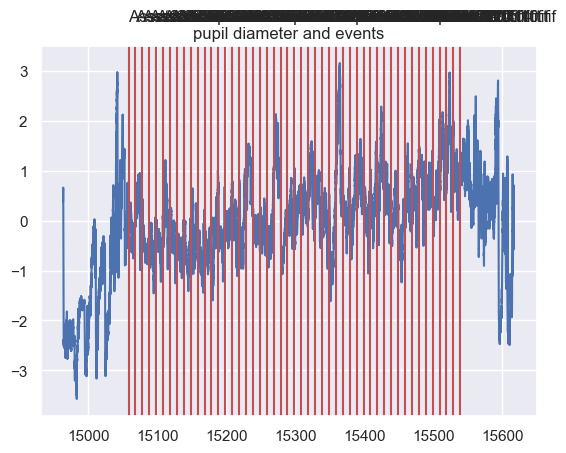

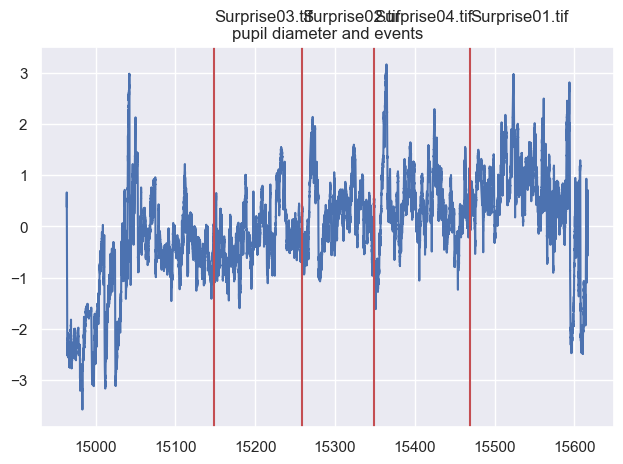

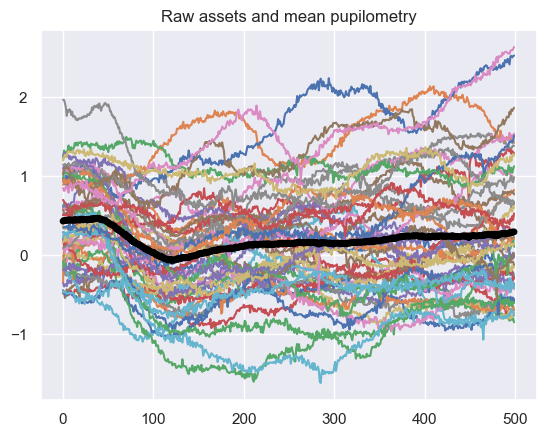

In [ ]:
%matplotlib inline
sns.set_theme()
fig, ax=plt.subplots(1,1)
ax.plot(pupil_left_eye['pupil_timestamp'],pupil_left_eye['diameter_3d'])
for  index, row in annotations_pd[filter_events].iterrows():
    plt.axvline(row['timestamp'], color='r', label='axvline - full height')
    ax.text((row['timestamp']),4,row['label'])
ax.set_title('pupil diameter and events')    

fig, ax=plt.subplots(1,1)
ax.plot(pupil_left_eye['pupil_timestamp'],pupil_left_eye['diameter_3d'])
for  index, row in annotations_pd[filter_events_surprise].iterrows():
    plt.axvline(row['timestamp'], color='r', label='axvline - full height')
    ax.text((row['timestamp']),4,row['label'])
ax.set_title('pupil diameter and events')    
plt.tight_layout()

fig, ax=plt.subplots(1,1)
ax.plot(pupil_matrix[0:500,:])
ax.plot(np.mean(pupil_matrix[0:500,:],axis=1),linewidth=5,color='black')
# ax.legend([images,'assets mean'])
ax.set_title('Raw assets and mean pupilometry')

In [ ]:
images
all_events=annotations_pd.values.flatten()

### Now lets compare assets with surprise assets


In [ ]:
#first extract a matrixt with normal assets
event_annotations=annotations_pd.loc[filter_assets,['label']]
pupil_df=pupil_right_eye

pupil_events_matrix=np.zeros([pupil_df.shape[0],len(event_annotations)])

for num,im in enumerate(event_annotations.values.flatten()):
    initial_anotation,end_anotation=cm.extract_annotations_timestamps(im,'label',annotations_pd)
    segmented_df=cm.filter_rows_by_temporal_values(
        dataframe=pupil_df,
        time_column='pupil_timestamp',
        ini_value=initial_anotation['timestamp'].values[0],
        end_value=end_anotation['timestamp'].values[0]
        )

    pupil_events_matrix[0:len(segmented_df),num]=segmented_df['diameter_3d']

#Now extract matrix with suprise assets
surprise_annotations=annotations_pd.loc[filter_events_surprise,['label']]
pupil_surprise_matrix=np.zeros([pupil_df.shape[0],len(surprise_annotations)])

for num,im in enumerate(surprise_annotations.values.flatten()):
    initial_anotation,end_anotation=cm.extract_annotations_timestamps(im,'label',annotations_pd)
    segmented_df=cm.filter_rows_by_temporal_values(
        dataframe=pupil_df,
        time_column='pupil_timestamp',
        ini_value=initial_anotation['timestamp'].values[0],
        end_value=end_anotation['timestamp'].values[0]
        )

    pupil_surprise_matrix[0:len(segmented_df),num]=segmented_df['diameter_3d']

Text(0.5, 1.0, 'Raw assets and mean pupilometry')

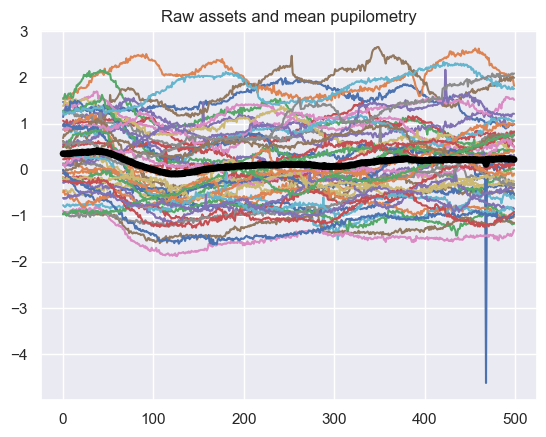

In [ ]:
fig, ax=plt.subplots(1,1)
ax.plot(pupil_events_matrix[0:500,:])
ax.plot(np.mean(pupil_events_matrix[0:500,:],axis=1),linewidth=5,color='black')
# ax.legend([images,'assets mean'])
ax.set_title('Raw assets and mean pupilometry')

Text(0.5, 1.0, 'Raw surprise and mean pupilometry')

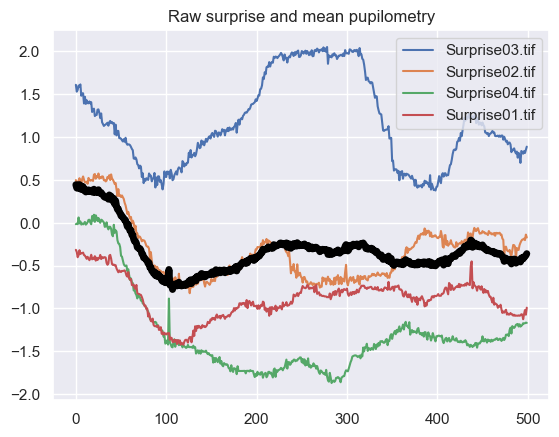

In [ ]:
fig, ax=plt.subplots(1,1)
ax.plot(pupil_surprise_matrix[0:500,:])
ax.plot(np.mean(pupil_surprise_matrix[0:500,:],axis=1),linewidth=5,color='black')
ax.legend(surprise_annotations.values.flatten())
ax.set_title('Raw surprise and mean pupilometry')

Text(0.5, 1.0, 'Mean pupilometry')

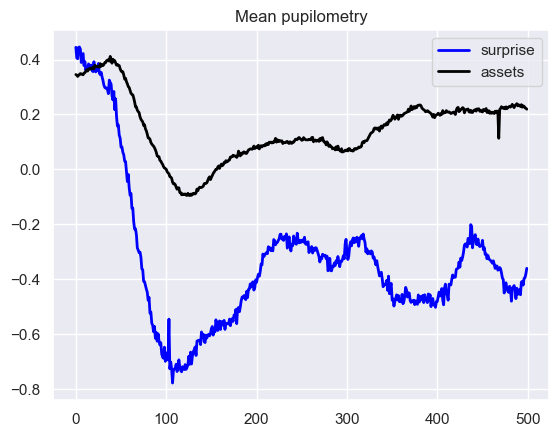

In [ ]:
fig, ax=plt.subplots(1,1)
ax.plot(np.mean(pupil_surprise_matrix[0:500,:],axis=1),linewidth=2,color='blue')
ax.plot(np.mean(pupil_events_matrix[0:500,:],axis=1),linewidth=2,color='black')
ax.legend(['surprise','assets'])
ax.set_title('Mean pupilometry')

C:\Users\Bolo\AppData\Local\Temp\ipykernel_16860\3538598048.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pupil_df['speed']=pupil_df['diameter_3d'].diff()


<AxesSubplot: >

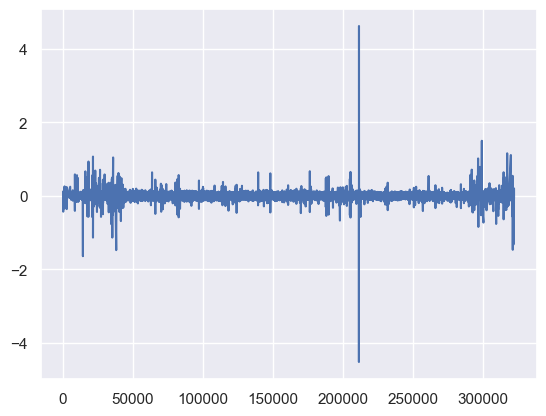

In [ ]:
pupil_df['speed']=pupil_df['diameter_3d'].diff()
pupil_df['speed'].plot()

### Since I only have one subject, a good way to maibe reduce dispersion is to meassure the speed of change

In [ ]:

event_annotations=annotations_pd.loc[filter_assets,['label']]
pupil_df=pupil_right_eye
pupil_df['speed']=abs(pupil_df['diameter_3d'].diff(periods=100))
y='speed'
pupil_events_matrix=np.zeros([pupil_df.shape[0],len(event_annotations)])

for num,im in enumerate(event_annotations.values.flatten()):
    initial_anotation,end_anotation=cm.extract_annotations_timestamps(im,'label',annotations_pd)
    segmented_df=cm.filter_rows_by_temporal_values(
        dataframe=pupil_df,
        time_column='pupil_timestamp',
        ini_value=initial_anotation['timestamp'].values[0],
        end_value=end_anotation['timestamp'].values[0]
        )

    pupil_events_matrix[0:len(segmented_df),num]=segmented_df[y]

#Now extract matrix with suprise assets
surprise_annotations=annotations_pd.loc[filter_events_surprise,['label']]
pupil_surprise_matrix=np.zeros([pupil_df.shape[0],len(surprise_annotations)])

for num,im in enumerate(surprise_annotations.values.flatten()):
    initial_anotation,end_anotation=cm.extract_annotations_timestamps(im,'label',annotations_pd)
    segmented_df=cm.filter_rows_by_temporal_values(
        dataframe=pupil_df,
        time_column='pupil_timestamp',
        ini_value=initial_anotation['timestamp'].values[0],
        end_value=end_anotation['timestamp'].values[0]
        )

    pupil_surprise_matrix[0:len(segmented_df),num]=segmented_df[y]

#Now extract matrix with blanks

#Now extract matrix with suprise assets
event_annotations=annotations_pd.loc[filter_events_blank,['label']]
pupil_blank_matrix=np.zeros([pupil_df.shape[0],len(event_annotations)])

for num,im in enumerate(event_annotations.values.flatten()):
    initial_anotation,end_anotation=cm.extract_annotations_timestamps(im,'label',annotations_pd)
    print(initial_anotation,end_anotation)
    segmented_df=cm.filter_rows_by_temporal_values(
        dataframe=pupil_df,
        time_column='pupil_timestamp',
        ini_value=initial_anotation['timestamp'].values[0],
        end_value=end_anotation['timestamp'].values[0]
        )

    pupil_blank_matrix[0:len(segmented_df),num]=segmented_df[y]


C:\Users\Bolo\AppData\Local\Temp\ipykernel_16860\2488134976.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pupil_df['speed']=abs(pupil_df['diameter_3d'].diff(periods=100))


   index     timestamp    label  duration
0   5377  15054.349196  blank_0       NaN    index     timestamp          label  duration
1   5496  15056.335982  drift_point_0       NaN
   index     timestamp    label  duration
3   5974  15064.356769  blank_1       NaN    index     timestamp          label  duration
4   6093  15066.352821  drift_point_1       NaN
   index     timestamp    label  duration
6   6573  15074.377335  blank_2       NaN    index     timestamp          label  duration
7   6691  15076.369297  drift_point_2       NaN
   index     timestamp    label  duration
9   7170  15084.393327  blank_3       NaN     index     timestamp          label  duration
10   7289  15086.386098  drift_point_3       NaN
    index     timestamp    label  duration
12   7767  15094.400903  blank_4       NaN     index     timestamp          label  duration
13   7886  15096.386383  drift_point_4       NaN
    index     timestamp    label  duration
15   8365  15104.410398  blank_5       NaN     inde

Text(0, 0.5, 'speed (s)')

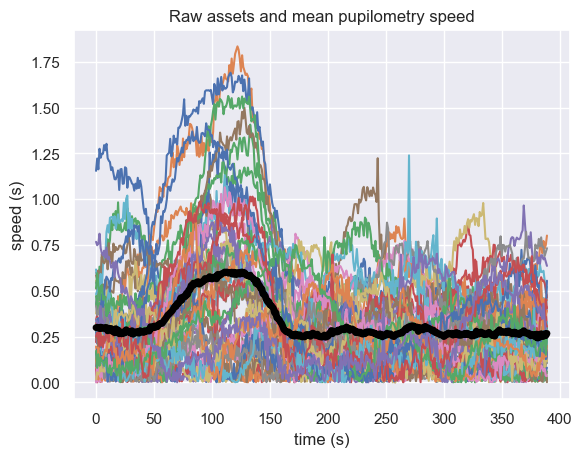

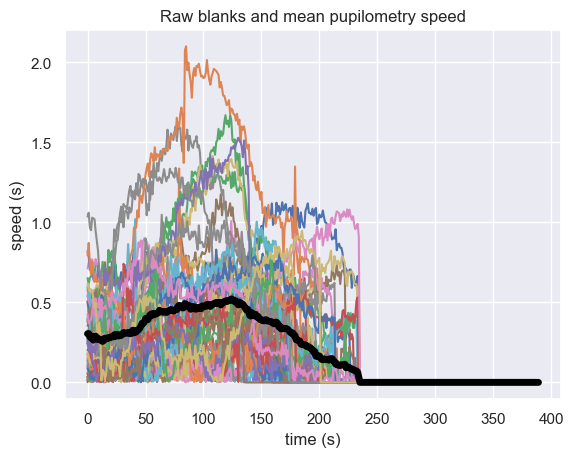

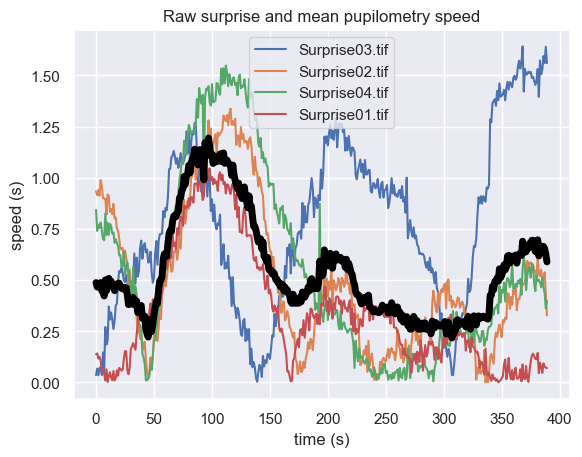

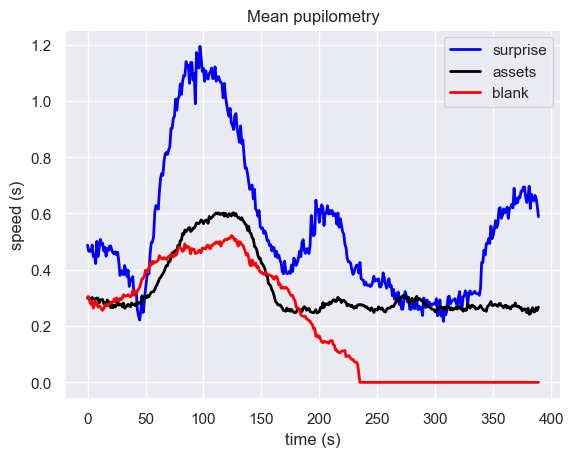

In [ ]:
window=range(10,400)

mat=pupil_events_matrix
fig, ax=plt.subplots(1,1)
ax.plot(mat[window])
ax.plot(np.mean(mat[window,:],axis=1),linewidth=5,color='black')
# ax.legend([images,'assets mean'])
ax.set_title('Raw assets and mean pupilometry speed')
ax.set_xlabel('time (s)')
ax.set_ylabel('speed (s)')

mat=pupil_blank_matrix

fig, ax=plt.subplots(1,1)
ax.plot(mat[window])
ax.plot(np.mean(mat[window,:],axis=1),linewidth=5,color='black')
# ax.legend([images,'assets mean'])
ax.set_title('Raw blanks and mean pupilometry speed')
ax.set_xlabel('time (s)')
ax.set_ylabel('speed (s)')

mat=pupil_surprise_matrix
fig, ax=plt.subplots(1,1)
ax.plot(mat[window,:])
ax.plot(np.mean(mat[window,:],axis=1),linewidth=5,color='black')
ax.legend(surprise_annotations.values.flatten())
ax.set_title('Raw surprise and mean pupilometry speed')
ax.set_xlabel('time (s)')
ax.set_ylabel('speed (s)')

fig, ax=plt.subplots(1,1)
ax.plot(np.mean(pupil_surprise_matrix[window,:],axis=1),linewidth=2,color='blue')
ax.plot(np.mean(pupil_events_matrix[window,:],axis=1),linewidth=2,color='black')
ax.plot(np.mean(pupil_blank_matrix[window,:],axis=1),linewidth=2,color='red')

ax.legend(['surprise','assets','blank'])
ax.set_title('Mean pupilometry')
ax.set_xlabel('time (s)')
ax.set_ylabel('speed (s)')

In [ ]:
pupil_events_matrix_blank=pupil_blank_matrix/blank_norm[:,None]


ValueError: operands could not be broadcast together with shapes (67325,49) (49,1) 

## Ideas:
1) spectral analysis of frequencies
2) signal processing
3) blank normalization
4) read papers


## what about blank normalization


In [ ]:
window=range(10,400)
blank_norm=np.mean(pupil_blank_matrix[window,:],axis=0)
pupil_events_matrix_blank=pupil_events_matrix/blank_norm
pupil_suprise_matrix_blank=pupil_surprise_matrix/blank_norm
pupil_blank_matrix_blank=pupil_blank_matrix/blank_norm


mat=pupil_events_matrix_blank
fig, ax=plt.subplots(1,1)
ax.plot(mat[window])
ax.plot(np.mean(mat[window,:],axis=1),linewidth=5,color='black')
# ax.legend([images,'assets mean'])
ax.set_title('Raw assets and mean pupilometry speed')
ax.set_xlabel('time (s)')
ax.set_ylabel('speed (s)')

mat=pupil_blank_matrix_blank

fig, ax=plt.subplots(1,1)
ax.plot(mat[window])
ax.plot(np.mean(mat[window,:],axis=1),linewidth=5,color='black')
# ax.legend([images,'assets mean'])
ax.set_title('Raw blanks and mean pupilometry speed')
ax.set_xlabel('time (s)')
ax.set_ylabel('speed (s)')

mat=pupil_suprise_matrix_blank
fig, ax=plt.subplots(1,1)
ax.plot(mat[window,:])
ax.plot(np.mean(mat[window,:],axis=1),linewidth=5,color='black')
ax.legend(surprise_annotations.values.flatten())
ax.set_title('Raw surprise and mean pupilometry speed')
ax.set_xlabel('time (s)')
ax.set_ylabel('speed (s)')

fig, ax=plt.subplots(1,1)
ax.plot(np.mean(pupil_suprise_matrix_blank[window,:],axis=1),linewidth=2,color='blue')
ax.plot(np.mean(pupil_events_matrix_blank[window,:],axis=1),linewidth=2,color='black')
ax.plot(np.mean(pupil_blank_matrix_blank[window,:],axis=1),linewidth=2,color='red')

ax.legend(['surprise','assets','blank'])
ax.set_title('Mean pupilometry')
ax.set_xlabel('time (s)')
ax.set_ylabel('speed (s)')

ValueError: operands could not be broadcast together with shapes (67325,45) (49,) 

In [ ]:
filter_events=annotations_pd['label'].str.contains('Asset') | annotations_pd['label'].str.contains('Control') | annotations_pd['label'].str.contains('Surprise')
filter_assets=annotations_pd['label'].str.contains('Asset') 

filter_events_surprise= annotations_pd['label'].str.contains('Surprise')
filter_events_blank= annotations_pd['label'].str.contains('blank')


In [35]:

event=annotations_pd.loc[filter_assets,['label']]
pupil_df=pupil_right_eye
pupil_df['speed']=abs(pupil_df['diameter_3d'].diff(periods=100))
y='diameter_3d'



pupil_events_matrix=np.zeros([pupil_df.shape[0],len(event)])

for num,im in enumerate(event.values.flatten()):
    initial_anotation,end_anotation,index_annotation=cm.extract_annotations_timestamps(im,'label',annotations_pd)
    # print(annotations_pd.iloc[index_annotation],annotations_pd.iloc[index_annotation-1])
    ini_blank=annotations_pd.iloc[index_annotation-1]
    ini_blank_val=annotations_pd.iloc[index_annotation-1,annotations_pd.columns.get_loc('timestamp')].values[0]
    end_blank=annotations_pd.iloc[index_annotation]
    end_blank_value=annotations_pd.iloc[index_annotation,annotations_pd.columns.get_loc('timestamp')].values[0]

    print(ini_blank)
    print(ini_blank_val)
    print(end_blank)
    print(end_blank_value)

    blank_df=cm.filter_rows_by_temporal_values(
                                dataframe=pupil_df,
                                time_column='pupil_timestamp',
                                ini_value=ini_blank_val,
                                end_value=end_blank_value
                                ) 

    display(blank_df)
    


    segmented_df=cm.filter_rows_by_temporal_values(
        dataframe=pupil_df,
        time_column='pupil_timestamp',
        ini_value=initial_anotation['timestamp'].values[0],
        end_value=end_anotation['timestamp'].values[0]
        )

    pupil_events_matrix[0:len(segmented_df),num]=segmented_df[y]

# #Now extract matrix with suprise assets
# surprise_annotations=annotations_pd.loc[filter_events_surprise,['label']]
# pupil_surprise_matrix=np.zeros([pupil_df.shape[0],len(surprise_annotations)])

# for num,im in enumerate(surprise_annotations.values.flatten()):
#     initial_anotation,end_anotation=cm.extract_annotations_timestamps(im,'label',annotations_pd)
#     segmented_df=cm.filter_rows_by_temporal_values(
#         dataframe=pupil_df,
#         time_column='pupil_timestamp',
#         ini_value=initial_anotation['timestamp'].values[0],
#         end_value=end_anotation['timestamp'].values[0]
#         )

#     pupil_surprise_matrix[0:len(segmented_df),num]=segmented_df[y]

# #Now extract matrix with blanks

# #Now extract matrix with suprise assets
# event_annotations=annotations_pd.loc[filter_events_blank,['label']]
# pupil_blank_matrix=np.zeros([pupil_df.shape[0],len(event_annotations)])

# for num,im in enumerate(event_annotations.values.flatten()):
#     initial_anotation,end_anotation=cm.extract_annotations_timestamps(im,'label',annotations_pd)
#     print(initial_anotation,end_anotation)
#     segmented_df=cm.filter_rows_by_temporal_values(
#         dataframe=pupil_df,
#         time_column='pupil_timestamp',
#         ini_value=initial_anotation['timestamp'].values[0],
#         end_value=end_anotation['timestamp'].values[0]
#         )

#     pupil_blank_matrix[0:len(segmented_df),num]=segmented_df[y]




C:\Users\Bolo\AppData\Local\Temp\ipykernel_21324\982053035.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pupil_df['speed']=abs(pupil_df['diameter_3d'].diff(periods=100))


   index     timestamp    label  duration
0   5377  15054.349196  blank_0       NaN
15054.34919560218
   index     timestamp          label  duration
1   5496  15056.335982  drift_point_0       NaN
15056.335982400002


,pupil_timestamp,world_index,eye_id,confidence,norm_pos_x,norm_pos_y,diameter,method,ellipse_center_x,ellipse_center_y,...,circle_3d_normal_z,circle_3d_radius,theta,phi,projected_sphere_center_x,projected_sphere_center_y,projected_sphere_axis_a,projected_sphere_axis_b,projected_sphere_angle,speed
43421,15054.356030,5378,0,1.0,0.376038,0.496568,30.640137,pye3d 0.3.0 real-time,72.199356,96.658972,...,-0.803772,1.735338,1.342643,-2.171115,118.415583,81.315511,158.154237,158.154237,0.0,0.021018
43425,15054.364049,5378,0,1.0,0.376093,0.496178,30.819934,pye3d 0.3.0 real-time,72.209856,96.733803,...,-0.802043,1.745365,1.341821,-2.173974,118.415583,81.315511,158.154237,158.154237,0.0,0.123560
43429,15054.372089,5379,0,1.0,0.376334,0.496036,30.917913,pye3d 0.3.0 real-time,72.256071,96.761119,...,-0.799899,1.750423,1.342786,-2.178166,118.415583,81.315511,158.154237,158.154237,0.0,0.200004
43432,15054.380040,5379,0,1.0,0.375887,0.496698,31.027039,pye3d 0.3.0 real-time,72.170240,96.633925,...,-0.798129,1.756454,1.342123,-2.181122,118.415583,81.315511,158.154237,158.154237,0.0,0.230840
43436,15054.388039,5380,0,1.0,0.376280,0.496136,30.824837,pye3d 0.3.0 real-time,72.245753,96.741961,...,-0.798055,1.744770,1.339165,-2.180263,118.415583,81.315511,158.154237,158.154237,0.0,0.115519
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44381,15056.292055,5493,0,1.0,0.374989,0.420692,32.323457,pye3d 0.3.0 real-time,71.997827,111.227061,...,-0.696888,1.833828,1.153468,-2.274712,118.457781,81.059510,158.847709,158.847709,0.0,0.324023
44384,15056.304018,5494,0,1.0,0.375229,0.420988,32.238697,pye3d 0.3.0 real-time,72.043991,111.170258,...,-0.698183,1.828884,1.155070,-2.273359,118.457781,81.059510,158.847709,158.847709,0.0,0.311629
44389,15056.312025,5494,0,1.0,0.375192,0.420511,32.149989,pye3d 0.3.0 real-time,72.036833,111.261824,...,-0.697402,1.823944,1.153664,-2.273945,118.457781,81.059510,158.847709,158.847709,0.0,0.314866
44393,15056.320025,5495,0,1.0,0.375095,0.420664,32.244122,pye3d 0.3.0 real-time,72.018255,111.232472,...,-0.697396,1.829325,1.153044,-2.273631,118.457781,81.059510,158.847709,158.847709,0.0,0.315349


   index     timestamp    label  duration
3   5974  15064.356769  blank_1       NaN
15064.35676948297
   index     timestamp          label  duration
4   6093  15066.352821  drift_point_1       NaN
15066.352821400002


,pupil_timestamp,world_index,eye_id,confidence,norm_pos_x,norm_pos_y,diameter,method,ellipse_center_x,ellipse_center_y,...,circle_3d_normal_z,circle_3d_radius,theta,phi,projected_sphere_center_x,projected_sphere_center_y,projected_sphere_axis_a,projected_sphere_axis_b,projected_sphere_angle,speed
48383,15064.364059,5975,0,1.0,0.333036,0.532629,30.081430,pye3d 0.3.0 real-time,63.942826,89.735238,...,-0.750848,1.733437,1.454428,-2.284472,117.501436,81.564218,156.898246,156.898246,0.0,0.093196
48387,15064.372028,5975,0,1.0,0.333188,0.532470,30.020258,pye3d 0.3.0 real-time,63.972073,89.765838,...,-0.750093,1.729623,1.454487,-2.285640,117.501436,81.564218,156.898246,156.898246,0.0,0.137822
48389,15064.380064,5976,0,1.0,0.333032,0.533008,30.061642,pye3d 0.3.0 real-time,63.942115,89.662460,...,-0.750865,1.732206,1.454954,-2.284517,117.501436,81.564218,156.898246,156.898246,0.0,0.073354
48393,15064.388030,5976,0,1.0,0.331403,0.536275,30.150562,pye3d 0.3.0 real-time,63.629405,89.035121,...,-0.749329,1.737871,1.460430,-2.287590,117.501436,81.564218,156.898246,156.898246,0.0,0.061738
48398,15064.396025,5977,0,1.0,0.330289,0.539509,29.844159,pye3d 0.3.0 real-time,63.415541,88.414288,...,-0.749231,1.720421,1.465207,-2.288334,117.501436,81.564218,156.898246,156.898246,0.0,0.178801
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49349,15066.316024,6091,0,1.0,0.374255,0.517990,29.717863,pye3d 0.3.0 real-time,71.857007,92.545967,...,-0.826168,1.691116,1.404075,-2.148380,117.416866,81.642690,157.164819,157.164819,0.0,0.216182
49353,15066.324039,6092,0,1.0,0.373604,0.517754,29.746829,pye3d 0.3.0 real-time,71.732025,92.591239,...,-0.825220,1.693138,1.402227,-2.149660,117.416866,81.642690,157.164819,157.164819,0.0,0.220126
49357,15066.332028,6092,0,1.0,0.374119,0.517613,29.707685,pye3d 0.3.0 real-time,71.830788,92.618279,...,-0.827588,1.690973,1.404035,-2.145726,117.416866,81.642690,157.164819,157.164819,0.0,0.199268
49360,15066.340031,6093,0,1.0,0.374053,0.517607,29.731876,pye3d 0.3.0 real-time,71.818272,92.619382,...,-0.827697,1.692431,1.405073,-2.145792,117.416866,81.642690,157.164819,157.164819,0.0,0.171293


   index     timestamp    label  duration
6   6573  15074.377335  blank_2       NaN
15074.377335400002
   index     timestamp          label  duration
7   6691  15076.369297  drift_point_2       NaN
15076.369297400002


,pupil_timestamp,world_index,eye_id,confidence,norm_pos_x,norm_pos_y,diameter,method,ellipse_center_x,ellipse_center_y,...,circle_3d_normal_z,circle_3d_radius,theta,phi,projected_sphere_center_x,projected_sphere_center_y,projected_sphere_axis_a,projected_sphere_axis_b,projected_sphere_angle,speed
53351,15074.384111,6573,0,1.0,0.384495,0.509420,34.241147,pye3d 0.3.0 real-time,73.823076,94.191305,...,-0.781224,1.953427,1.355983,-2.214961,117.264304,81.069255,156.158381,156.158381,0.0,0.654900
53353,15074.392007,6573,0,1.0,0.384468,0.509526,34.157915,pye3d 0.3.0 real-time,73.817831,94.171031,...,-0.780265,1.948396,1.354084,-2.216041,117.264304,81.069255,156.158381,156.158381,0.0,0.683463
53357,15074.400033,6574,0,1.0,0.384227,0.509447,34.396398,pye3d 0.3.0 real-time,73.771630,94.186206,...,-0.779182,1.962148,1.352523,-2.217425,117.264304,81.069255,156.158381,156.158381,0.0,0.770364
53360,15074.408043,6574,0,1.0,0.384334,0.509362,34.333080,pye3d 0.3.0 real-time,73.792152,94.202551,...,-0.778235,1.958223,1.352640,-2.219068,117.264304,81.069255,156.158381,156.158381,0.0,0.705355
53364,15074.416075,6575,0,1.0,0.384431,0.509317,34.335738,pye3d 0.3.0 real-time,73.810739,94.211070,...,-0.777828,1.958222,1.351533,-2.219434,117.264304,81.069255,156.158381,156.158381,0.0,0.639624
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54313,15076.328044,6689,0,1.0,0.375317,0.505893,30.225666,pye3d 0.3.0 real-time,72.060837,94.868490,...,-0.780081,1.722050,1.363897,-2.219147,117.547257,81.808998,156.673273,156.673273,0.0,0.082758
54317,15076.336025,6689,0,1.0,0.375123,0.506053,30.409721,pye3d 0.3.0 real-time,72.023606,94.837854,...,-0.779432,1.732592,1.366455,-2.220947,117.547257,81.808998,156.673273,156.673273,0.0,0.040819
54320,15076.344032,6690,0,1.0,0.375513,0.506217,30.334846,pye3d 0.3.0 real-time,72.098400,94.806289,...,-0.780171,1.728099,1.367899,-2.220092,117.547257,81.808998,156.673273,156.673273,0.0,0.072090
54324,15076.351997,6690,0,1.0,0.379921,0.507396,30.095661,pye3d 0.3.0 real-time,72.944872,94.579939,...,-0.789812,1.712650,1.371347,-2.204591,117.547257,81.808998,156.673273,156.673273,0.0,0.131791


   index     timestamp    label  duration
9   7170  15084.393327  blank_3       NaN
15084.393327125345
    index     timestamp          label  duration
10   7289  15086.386098  drift_point_3       NaN
15086.386098400002


,pupil_timestamp,world_index,eye_id,confidence,norm_pos_x,norm_pos_y,diameter,method,ellipse_center_x,ellipse_center_y,...,circle_3d_normal_z,circle_3d_radius,theta,phi,projected_sphere_center_x,projected_sphere_center_y,projected_sphere_axis_a,projected_sphere_axis_b,projected_sphere_angle,speed
58312,15084.400031,7171,0,1.000000,0.375675,0.484266,28.736451,pye3d 0.3.0 real-time,72.129695,99.020964,...,-0.774002,1.643513,1.321076,-2.216329,117.285559,81.857080,156.444986,156.444986,0.0,0.001917
58316,15084.408056,7171,0,1.000000,0.375614,0.484253,28.716175,pye3d 0.3.0 real-time,72.117933,99.023445,...,-0.774043,1.642400,1.318689,-2.215446,117.285559,81.857080,156.444986,156.444986,0.0,0.025446
58321,15084.416059,7172,0,1.000000,0.375660,0.484268,28.729381,pye3d 0.3.0 real-time,72.126710,99.020480,...,-0.774398,1.643186,1.318278,-2.214695,117.285559,81.857080,156.444986,156.444986,0.0,0.007634
58324,15084.424043,7172,0,1.000000,0.375498,0.484572,28.691648,pye3d 0.3.0 real-time,72.095615,98.962094,...,-0.775410,1.641217,1.318972,-2.213192,117.285559,81.857080,156.444986,156.444986,0.0,0.019557
58330,15084.432042,7173,0,1.000000,0.375527,0.484306,28.871844,pye3d 0.3.0 real-time,72.101227,99.013201,...,-0.775750,1.651710,1.317420,-2.212069,117.285559,81.857080,156.444986,156.444986,0.0,0.069681
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59282,15086.352004,7287,0,0.995879,0.380506,0.521243,29.629025,pye3d 0.3.0 real-time,73.057238,91.921343,...,-0.802022,1.678646,1.425113,-2.196402,117.212768,81.904866,156.930234,156.930234,0.0,0.308368
59287,15086.360003,7288,0,1.000000,0.380569,0.521342,29.579478,pye3d 0.3.0 real-time,73.069280,91.902419,...,-0.801256,1.675615,1.423868,-2.197469,117.212768,81.904866,156.930234,156.930234,0.0,0.333218
59291,15086.367996,7288,0,1.000000,0.380656,0.521566,29.515232,pye3d 0.3.0 real-time,73.085903,91.859323,...,-0.800869,1.671770,1.424400,-2.198245,117.212768,81.904866,156.930234,156.930234,0.0,0.267851
59294,15086.376003,7289,0,1.000000,0.380580,0.521362,29.597427,pye3d 0.3.0 real-time,73.071376,91.898504,...,-0.800592,1.676506,1.422849,-2.198405,117.212768,81.904866,156.930234,156.930234,0.0,0.301692


    index     timestamp    label  duration
12   7767  15094.400903  blank_4       NaN
15094.4009034
    index     timestamp          label  duration
13   7886  15096.386383  drift_point_4       NaN
15096.386383400002


,pupil_timestamp,world_index,eye_id,confidence,norm_pos_x,norm_pos_y,diameter,method,ellipse_center_x,ellipse_center_y,...,circle_3d_normal_z,circle_3d_radius,theta,phi,projected_sphere_center_x,projected_sphere_center_y,projected_sphere_axis_a,projected_sphere_axis_b,projected_sphere_angle,speed
63273,15094.404041,7768,0,1.0,0.418142,0.448478,27.959936,pye3d 0.3.0 real-time,80.283174,105.892256,...,-0.805684,1.581554,1.224423,-2.113036,117.078082,81.878806,156.970145,156.970145,0.0,0.402857
63277,15094.411999,7768,0,1.0,0.417800,0.448526,28.009937,pye3d 0.3.0 real-time,80.217572,105.882919,...,-0.806159,1.584652,1.227229,-2.113731,117.078082,81.878806,156.970145,156.970145,0.0,0.379108
63281,15094.420011,7769,0,1.0,0.417835,0.448165,27.875257,pye3d 0.3.0 real-time,80.224298,105.952227,...,-0.808063,1.577414,1.229386,-2.111088,117.078082,81.878806,156.970145,156.970145,0.0,0.376362
63285,15094.428018,7769,0,1.0,0.417750,0.448186,27.845816,pye3d 0.3.0 real-time,80.208034,105.948246,...,-0.809698,1.576043,1.230476,-2.108356,117.078082,81.878806,156.970145,156.970145,0.0,0.428226
63291,15094.436031,7770,0,1.0,0.417650,0.448105,27.813912,pye3d 0.3.0 real-time,80.188804,105.963782,...,-0.810585,1.574454,1.230620,-2.106600,117.078082,81.878806,156.970145,156.970145,0.0,0.449239
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64236,15096.348008,7884,0,1.0,0.379015,0.498496,28.616521,pye3d 0.3.0 real-time,72.770826,96.288809,...,-0.807137,1.639117,1.354737,-2.168998,116.563294,81.676329,155.998903,155.998903,0.0,0.217502
64243,15096.356012,7884,0,1.0,0.379168,0.498394,28.530989,pye3d 0.3.0 real-time,72.800215,96.308303,...,-0.808549,1.634355,1.353745,-2.166105,116.563294,81.676329,155.998903,155.998903,0.0,0.160027
64247,15096.363996,7885,0,1.0,0.379222,0.498444,28.599348,pye3d 0.3.0 real-time,72.810677,96.298720,...,-0.808839,1.638295,1.353754,-2.165577,116.563294,81.676329,155.998903,155.998903,0.0,0.222286
64249,15096.371988,7885,0,1.0,0.379160,0.498634,28.660577,pye3d 0.3.0 real-time,72.798696,96.262226,...,-0.808660,1.641782,1.353724,-2.165894,116.563294,81.676329,155.998903,155.998903,0.0,0.187886


    index     timestamp    label  duration
15   8365  15104.410398  blank_5       NaN
15104.41039836376
    index     timestamp          label  duration
16   8484  15106.402763  drift_point_5       NaN
15106.4027634


,pupil_timestamp,world_index,eye_id,confidence,norm_pos_x,norm_pos_y,diameter,method,ellipse_center_x,ellipse_center_y,...,circle_3d_normal_z,circle_3d_radius,theta,phi,projected_sphere_center_x,projected_sphere_center_y,projected_sphere_axis_a,projected_sphere_axis_b,projected_sphere_angle,speed
68237,15104.416029,8365,0,1.0,0.330929,0.531820,28.696690,pye3d 0.3.0 real-time,63.538273,89.890589,...,-0.736603,1.649542,1.440442,-2.304192,117.489774,81.750872,157.071947,157.071947,0.0,0.426924
68241,15104.424021,8366,0,1.0,0.331011,0.531854,28.579766,pye3d 0.3.0 real-time,63.554146,89.883947,...,-0.736078,1.642598,1.439999,-2.304918,117.489774,81.750872,157.071947,157.071947,0.0,0.501913
68244,15104.432037,8366,0,1.0,0.330999,0.532081,28.785636,pye3d 0.3.0 real-time,63.551756,89.840521,...,-0.735404,1.654322,1.441390,-2.306133,117.489774,81.750872,157.071947,157.071947,0.0,0.314726
68249,15104.440006,8367,0,1.0,0.330903,0.532217,28.868949,pye3d 0.3.0 real-time,63.533346,89.814404,...,-0.734367,1.658988,1.441008,-2.307636,117.489774,81.750872,157.071947,157.071947,0.0,0.275787
68253,15104.447990,8367,0,1.0,0.330898,0.532612,29.085252,pye3d 0.3.0 real-time,63.532445,89.738416,...,-0.733999,1.671330,1.441473,-2.308254,117.489774,81.750872,157.071947,157.071947,0.0,0.193401
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69196,15106.355993,8481,0,1.0,0.379902,0.496260,27.631938,pye3d 0.3.0 real-time,72.941207,96.718019,...,-0.797665,1.564312,1.381177,-2.193640,117.653389,82.107673,157.504673,157.504673,0.0,0.290696
69202,15106.364027,8482,0,1.0,0.380995,0.496442,27.560834,pye3d 0.3.0 real-time,73.151054,96.683066,...,-0.800337,1.559943,1.382604,-2.189343,117.653389,82.107673,157.504673,157.504673,0.0,0.331995
69207,15106.371983,8482,0,1.0,0.382050,0.495425,27.716509,pye3d 0.3.0 real-time,73.353633,96.878452,...,-0.801887,1.568640,1.378415,-2.185475,117.653389,82.107673,157.504673,157.504673,0.0,0.261779
69208,15106.380015,8482,0,1.0,0.383808,0.493458,27.697727,pye3d 0.3.0 real-time,73.691069,97.256001,...,-0.802946,1.567132,1.374672,-2.182554,117.653389,82.107673,157.504673,157.504673,0.0,0.272726


    index     timestamp    label  duration
18   8963  15114.429097  blank_6       NaN
15114.4290974
    index     timestamp          label  duration
19   9082  15116.419574  drift_point_6       NaN
15116.4195744


,pupil_timestamp,world_index,eye_id,confidence,norm_pos_x,norm_pos_y,diameter,method,ellipse_center_x,ellipse_center_y,...,circle_3d_normal_z,circle_3d_radius,theta,phi,projected_sphere_center_x,projected_sphere_center_y,projected_sphere_axis_a,projected_sphere_axis_b,projected_sphere_angle,speed
73202,15114.432005,8963,0,1.0,0.361470,0.562914,31.105876,pye3d 0.3.0 real-time,69.402241,83.920466,...,-0.784715,1.764838,1.508397,-2.236884,117.859890,81.757495,157.253275,157.253275,0.0,0.464467
73204,15114.440037,8964,0,1.0,0.361583,0.562685,30.952190,pye3d 0.3.0 real-time,69.423863,83.964451,...,-0.787747,1.756592,1.509771,-2.232061,117.859890,81.757495,157.253275,157.253275,0.0,0.562263
73210,15114.448012,8964,0,1.0,0.362271,0.559930,30.927517,pye3d 0.3.0 real-time,69.556090,84.493401,...,-0.790668,1.755606,1.504961,-2.226884,117.859890,81.757495,157.253275,157.253275,0.0,0.603081
73214,15114.456028,8964,0,1.0,0.362089,0.562314,30.643306,pye3d 0.3.0 real-time,69.521024,84.035665,...,-0.793614,1.739710,1.508561,-2.222332,117.859890,81.757495,157.253275,157.253275,0.0,0.681368
73219,15114.464011,8965,0,1.0,0.362080,0.562741,30.735700,pye3d 0.3.0 real-time,69.519293,83.953819,...,-0.795583,1.745328,1.510186,-2.219203,117.859890,81.757495,157.253275,157.253275,0.0,0.626233
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74170,15116.384009,9080,0,1.0,0.376868,0.495242,28.575401,pye3d 0.3.0 real-time,72.358691,96.913446,...,-0.801311,1.619160,1.367860,-2.183495,117.813013,82.030860,157.700871,157.700871,0.0,0.794495
74172,15116.391992,9080,0,1.0,0.376734,0.494790,28.455554,pye3d 0.3.0 real-time,72.332832,97.000257,...,-0.800209,1.612359,1.366691,-2.185106,117.813013,82.030860,157.700871,157.700871,0.0,0.836494
74176,15116.399997,9080,0,1.0,0.376766,0.494986,28.506379,pye3d 0.3.0 real-time,72.339048,96.962663,...,-0.800656,1.615255,1.366466,-2.184248,117.813013,82.030860,157.700871,157.700871,0.0,0.770434
74180,15116.408012,9081,0,1.0,0.376865,0.494639,28.676105,pye3d 0.3.0 real-time,72.358042,97.029279,...,-0.800789,1.624982,1.363725,-2.183198,117.813013,82.030860,157.700871,157.700871,0.0,0.651705


    index     timestamp    label  duration
21   9561  15124.445613  blank_7       NaN
15124.4456134
    index     timestamp          label  duration
22   9679  15126.436341  drift_point_7       NaN
15126.436341400002


,pupil_timestamp,world_index,eye_id,confidence,norm_pos_x,norm_pos_y,diameter,method,ellipse_center_x,ellipse_center_y,...,circle_3d_normal_z,circle_3d_radius,theta,phi,projected_sphere_center_x,projected_sphere_center_y,projected_sphere_axis_a,projected_sphere_axis_b,projected_sphere_angle,speed
78168,15124.452010,9561,0,1.0,0.388140,0.500961,30.729091,pye3d 0.3.0 real-time,74.522830,95.815475,...,-0.797888,1.742727,1.364524,-2.188572,117.012092,81.562939,156.765824,156.765824,0.0,0.189603
78172,15124.459988,9562,0,1.0,0.387964,0.501222,30.594869,pye3d 0.3.0 real-time,74.489101,95.765455,...,-0.797664,1.735058,1.366605,-2.189576,117.012092,81.562939,156.765824,156.765824,0.0,0.184273
78177,15124.467983,9562,0,1.0,0.388093,0.500817,30.703917,pye3d 0.3.0 real-time,74.513912,95.843094,...,-0.796359,1.741071,1.365195,-2.191461,117.012092,81.562939,156.765824,156.765824,0.0,0.100610
78180,15124.475994,9562,0,1.0,0.388089,0.501198,30.686671,pye3d 0.3.0 real-time,74.513000,95.770054,...,-0.797532,1.740200,1.367796,-2.190154,117.012092,81.562939,156.765824,156.765824,0.0,0.088567
78184,15124.483985,9563,0,1.0,0.388046,0.501394,30.676031,pye3d 0.3.0 real-time,74.504791,95.732433,...,-0.796859,1.739437,1.367963,-2.191383,117.012092,81.562939,156.765824,156.765824,0.0,0.086476
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79132,15126.395982,9677,0,1.0,0.390562,0.493309,28.087212,pye3d 0.3.0 real-time,74.987854,97.284711,...,-0.901846,1.606023,1.386356,-1.980080,117.058365,81.852478,156.958601,156.958601,0.0,0.325473
79136,15126.404008,9678,0,1.0,0.390093,0.493602,28.213014,pye3d 0.3.0 real-time,74.897825,97.228453,...,-0.901792,1.613486,1.389106,-1.981391,117.058365,81.852478,156.958601,156.958601,0.0,0.281435
79141,15126.411982,9678,0,1.0,0.389520,0.494387,27.979778,pye3d 0.3.0 real-time,74.787886,97.077736,...,-0.901097,1.600104,1.393192,-1.984850,117.058365,81.852478,156.958601,156.958601,0.0,0.371221
79145,15126.419998,9679,0,1.0,0.389295,0.495038,28.182854,pye3d 0.3.0 real-time,74.744616,96.952649,...,-0.898654,1.611423,1.398507,-1.993071,117.058365,81.852478,156.958601,156.958601,0.0,0.217919


    index     timestamp    label  duration
24  10158  15134.459516  blank_8       NaN
15134.459516400002
    index     timestamp          label  duration
25  10277  15136.453133  drift_point_8       NaN
15136.453133400002


,pupil_timestamp,world_index,eye_id,confidence,norm_pos_x,norm_pos_y,diameter,method,ellipse_center_x,ellipse_center_y,...,circle_3d_normal_z,circle_3d_radius,theta,phi,projected_sphere_center_x,projected_sphere_center_y,projected_sphere_axis_a,projected_sphere_axis_b,projected_sphere_angle,speed
83128,15134.459975,10158,0,1.0,0.376428,0.455160,29.508396,pye3d 0.3.0 real-time,72.274190,104.609225,...,-0.741589,1.682857,1.231586,-2.236634,116.777100,81.647145,156.897387,156.897387,0.0,0.613619
83132,15134.467973,10159,0,1.0,0.376420,0.454779,29.543575,pye3d 0.3.0 real-time,72.272545,104.682361,...,-0.740737,1.684869,1.229532,-2.237171,116.777100,81.647145,156.897387,156.897387,0.0,0.675676
83137,15134.475979,10159,0,1.0,0.376501,0.454597,29.629144,pye3d 0.3.0 real-time,72.288154,104.717315,...,-0.740387,1.689725,1.229368,-2.237697,116.777100,81.647145,156.897387,156.897387,0.0,0.610738
83138,15134.483974,10160,0,1.0,0.376220,0.455012,29.581057,pye3d 0.3.0 real-time,72.234163,104.637763,...,-0.740239,1.686975,1.230839,-2.238614,116.777100,81.647145,156.897387,156.897387,0.0,0.628786
83145,15134.492005,10160,0,1.0,0.376463,0.454643,29.638033,pye3d 0.3.0 real-time,72.280875,104.708594,...,-0.741050,1.690376,1.230916,-2.237258,116.777100,81.647145,156.897387,156.897387,0.0,0.611939
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84099,15136.419966,10275,0,1.0,0.377765,0.496378,27.876012,pye3d 0.3.0 real-time,72.530806,96.695479,...,-0.804783,1.579614,1.356232,-2.173739,117.032624,81.821103,157.409492,157.409492,0.0,0.259347
84102,15136.428019,10276,0,1.0,0.377670,0.496570,27.818808,pye3d 0.3.0 real-time,72.512565,96.658480,...,-0.804270,1.576279,1.356796,-2.174842,117.032624,81.821103,157.409492,157.409492,0.0,0.286235
84109,15136.435998,10276,0,1.0,0.377767,0.496325,27.855311,pye3d 0.3.0 real-time,72.531305,96.705544,...,-0.803887,1.578298,1.357208,-2.175662,117.032624,81.821103,157.409492,157.409492,0.0,0.172327
84111,15136.443976,10277,0,1.0,0.377778,0.496477,27.914639,pye3d 0.3.0 real-time,72.533303,96.676512,...,-0.802231,1.581353,1.356489,-2.178411,117.032624,81.821103,157.409492,157.409492,0.0,0.196999


    index     timestamp     label  duration
30  11354  15154.485196  blank_10       NaN
15154.4851964
    index     timestamp           label  duration
31  11472  15156.470105  drift_point_10       NaN
15156.470105482971


,pupil_timestamp,world_index,eye_id,confidence,norm_pos_x,norm_pos_y,diameter,method,ellipse_center_x,ellipse_center_y,...,circle_3d_normal_z,circle_3d_radius,theta,phi,projected_sphere_center_x,projected_sphere_center_y,projected_sphere_axis_a,projected_sphere_axis_b,projected_sphere_angle,speed
93055,15154.488008,11354,0,1.000000,0.407939,0.478097,28.919491,pye3d 0.3.0 real-time,78.324349,100.205412,...,-0.829356,1.631697,1.330158,-2.118039,117.319096,82.127885,157.310691,157.310691,0.0,0.466884
93059,15154.495950,11354,0,1.000000,0.407931,0.477968,28.914623,pye3d 0.3.0 real-time,78.322785,100.230170,...,-0.829658,1.631513,1.327595,-2.116402,117.319096,82.127885,157.310691,157.310691,0.0,0.478892
93063,15154.504001,11355,0,1.000000,0.407684,0.477927,28.993164,pye3d 0.3.0 real-time,78.275283,100.237984,...,-0.828541,1.635945,1.326271,-2.118075,117.319096,82.127885,157.310691,157.310691,0.0,0.426331
93066,15154.511967,11355,0,1.000000,0.407931,0.477977,28.914794,pye3d 0.3.0 real-time,78.322750,100.228461,...,-0.828262,1.631286,1.324053,-2.117715,117.319096,82.127885,157.310691,157.310691,0.0,0.373186
93070,15154.519979,11356,0,1.000000,0.407958,0.477958,29.066919,pye3d 0.3.0 real-time,78.327849,100.232118,...,-0.828105,1.639890,1.323054,-2.117612,117.319096,82.127885,157.310691,157.310691,0.0,0.459432
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94021,15156.431980,11470,0,0.993766,0.387952,0.495771,32.806191,pye3d 0.3.0 real-time,74.486775,96.812009,...,-0.798758,1.864555,1.353752,-2.183757,117.298831,81.785709,156.774052,156.774052,0.0,0.677039
94023,15156.440019,11470,0,1.000000,0.388222,0.495675,32.711063,pye3d 0.3.0 real-time,74.538687,96.830449,...,-0.799098,1.858991,1.354155,-2.183277,117.298831,81.785709,156.774052,156.774052,0.0,0.647805
94029,15156.447973,11471,0,1.000000,0.387951,0.495953,32.622869,pye3d 0.3.0 real-time,74.486549,96.776974,...,-0.799594,1.854142,1.356102,-2.183002,117.298831,81.785709,156.774052,156.774052,0.0,0.604276
94033,15156.455954,11471,0,1.000000,0.388146,0.495702,32.709171,pye3d 0.3.0 real-time,74.524004,96.825142,...,-0.799928,1.859099,1.356947,-2.182668,117.298831,81.785709,156.774052,156.774052,0.0,0.618828


    index     timestamp     label  duration
33  11951  15164.498675  blank_11       NaN
15164.498675400002
    index     timestamp           label  duration
34  12070  15166.486851  drift_point_11       NaN
15166.48685148297


,pupil_timestamp,world_index,eye_id,confidence,norm_pos_x,norm_pos_y,diameter,method,ellipse_center_x,ellipse_center_y,...,circle_3d_normal_z,circle_3d_radius,theta,phi,projected_sphere_center_x,projected_sphere_center_y,projected_sphere_axis_a,projected_sphere_axis_b,projected_sphere_angle,speed
98019,15164.499959,11951,0,1.0,0.424099,0.507277,29.335500,pye3d 0.3.0 real-time,81.427007,94.602749,...,-0.849396,1.644068,1.408442,-2.104920,117.524755,81.849009,157.241216,157.241216,0.0,0.001249
98027,15164.515950,11952,0,1.0,0.419625,0.498946,28.769870,pye3d 0.3.0 real-time,80.567943,96.202317,...,-0.842893,1.615480,1.385974,-2.111207,117.524755,81.849009,157.241216,157.241216,0.0,0.174966
98035,15164.531956,11953,0,1.0,0.419500,0.499914,29.058737,pye3d 0.3.0 real-time,80.544081,96.016546,...,-0.844759,1.631939,1.388210,-2.108204,117.524755,81.849009,157.241216,157.241216,0.0,0.081138
98038,15164.539989,11954,0,1.0,0.419863,0.499373,28.939050,pye3d 0.3.0 real-time,80.613728,96.120439,...,-0.845785,1.625281,1.387335,-2.105889,117.524755,81.849009,157.241216,157.241216,0.0,0.160323
98042,15164.547985,11954,0,1.0,0.419670,0.499144,28.831366,pye3d 0.3.0 real-time,80.576603,96.164381,...,-0.847456,1.619626,1.385574,-2.101989,117.524755,81.849009,157.241216,157.241216,0.0,0.127071
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98988,15166.451971,12068,0,1.0,0.388666,0.407037,28.550527,pye3d 0.3.0 real-time,74.623828,113.848980,...,-0.711084,1.623242,1.141424,-2.243604,117.888485,82.254338,157.976692,157.976692,0.0,0.121944
98992,15166.459948,12068,0,1.0,0.388488,0.407302,28.484229,pye3d 0.3.0 real-time,74.589736,113.798012,...,-0.712353,1.619699,1.144734,-2.243261,117.888485,82.254338,157.976692,157.976692,0.0,0.045339
98996,15166.467938,12069,0,1.0,0.388055,0.407637,28.380057,pye3d 0.3.0 real-time,74.506591,113.733700,...,-0.712034,1.613834,1.143577,-2.243161,117.888485,82.254338,157.976692,157.976692,0.0,0.098430
99000,15166.475952,12069,0,1.0,0.387705,0.407440,28.291597,pye3d 0.3.0 real-time,74.439329,113.771525,...,-0.713143,1.609354,1.142867,-2.240794,117.888485,82.254338,157.976692,157.976692,0.0,0.016915


    index     timestamp     label  duration
36  12549  15174.514018  blank_12       NaN
15174.5140184
    index     timestamp           label  duration
37  12668  15176.503062  drift_point_12       NaN
15176.5030624


,pupil_timestamp,world_index,eye_id,confidence,norm_pos_x,norm_pos_y,diameter,method,ellipse_center_x,ellipse_center_y,...,circle_3d_normal_z,circle_3d_radius,theta,phi,projected_sphere_center_x,projected_sphere_center_y,projected_sphere_axis_a,projected_sphere_axis_b,projected_sphere_angle,speed
102987,15174.519956,12549,0,1.0,0.345983,0.521710,27.773837,pye3d 0.3.0 real-time,66.428831,91.831774,...,-0.771418,1.586990,1.418716,-2.246247,117.064479,81.842337,157.250251,157.250251,0.0,0.264164
102991,15174.527954,12550,0,1.0,0.346171,0.521773,27.742040,pye3d 0.3.0 real-time,66.464834,91.819584,...,-0.772580,1.585208,1.419690,-2.244550,117.064479,81.842337,157.250251,157.250251,0.0,0.262357
102994,15174.535952,12550,0,1.0,0.345768,0.522160,28.025456,pye3d 0.3.0 real-time,66.387469,91.745358,...,-0.771979,1.601613,1.419036,-2.245400,117.064479,81.842337,157.250251,157.250251,0.0,0.340414
102999,15174.543948,12551,0,1.0,0.345642,0.521866,27.863378,pye3d 0.3.0 real-time,66.363282,91.801782,...,-0.772205,1.592510,1.419678,-2.245155,117.064479,81.842337,157.250251,157.250251,0.0,0.271846
103002,15174.551938,12551,0,1.0,0.345436,0.521246,27.847539,pye3d 0.3.0 real-time,66.323735,91.920816,...,-0.771392,1.591762,1.418072,-2.246164,117.064479,81.842337,157.250251,157.250251,0.0,0.251719
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103953,15176.467932,12666,0,1.0,0.382483,0.490255,28.297501,pye3d 0.3.0 real-time,73.436680,97.871024,...,-0.784805,1.600383,1.361004,-2.210290,117.285900,81.931999,157.369446,157.369446,0.0,0.002333
103956,15176.475938,12666,0,1.0,0.382191,0.488948,28.373383,pye3d 0.3.0 real-time,73.380711,98.121999,...,-0.783636,1.605066,1.358024,-2.211433,117.285900,81.931999,157.369446,157.369446,0.0,0.039648
103958,15176.483951,12666,0,1.0,0.381370,0.488790,28.269052,pye3d 0.3.0 real-time,73.223013,98.152372,...,-0.783328,1.599669,1.356335,-2.211469,117.285900,81.931999,157.369446,157.369446,0.0,0.095476
103964,15176.492033,12667,0,1.0,0.381556,0.488952,28.361771,pye3d 0.3.0 real-time,73.258734,98.121297,...,-0.783701,1.604839,1.356531,-2.210888,117.285900,81.931999,157.369446,157.369446,0.0,0.044062


    index     timestamp     label  duration
39  13147  15184.526427  blank_13       NaN
15184.526427400002
    index     timestamp           label  duration
40  13265  15186.520064  drift_point_13       NaN
15186.520064400002


,pupil_timestamp,world_index,eye_id,confidence,norm_pos_x,norm_pos_y,diameter,method,ellipse_center_x,ellipse_center_y,...,circle_3d_normal_z,circle_3d_radius,theta,phi,projected_sphere_center_x,projected_sphere_center_y,projected_sphere_axis_a,projected_sphere_axis_b,projected_sphere_angle,speed
107947,15184.527966,13147,0,1.0,0.382699,0.490209,29.413549,pye3d 0.3.0 real-time,73.478156,97.879905,...,-0.793754,1.666469,1.307494,-2.176527,117.024346,81.903944,157.207255,157.207255,0.0,0.215775
107950,15184.535957,13147,0,1.0,0.382775,0.490180,29.431008,pye3d 0.3.0 real-time,73.492889,97.885458,...,-0.793675,1.667402,1.305807,-2.176011,117.024346,81.903944,157.207255,157.207255,0.0,0.248179
107955,15184.543963,13148,0,1.0,0.382813,0.490256,29.446483,pye3d 0.3.0 real-time,73.500075,97.870761,...,-0.793305,1.668170,1.305852,-2.176701,117.024346,81.903944,157.207255,157.207255,0.0,0.257190
107961,15184.551931,13148,0,1.0,0.382453,0.490204,29.402386,pye3d 0.3.0 real-time,73.431001,97.880909,...,-0.792984,1.665858,1.305987,-2.177338,117.024346,81.903944,157.207255,157.207255,0.0,0.303271
107965,15184.559943,13148,0,1.0,0.382540,0.490169,29.389329,pye3d 0.3.0 real-time,73.447607,97.887552,...,-0.793206,1.665104,1.305500,-2.176745,117.024346,81.903944,157.207255,157.207255,0.0,0.284750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108919,15186.487986,13264,0,1.0,0.383618,0.491559,28.973894,pye3d 0.3.0 real-time,73.654647,97.620717,...,-0.801738,1.649849,1.347523,-2.176424,116.793831,81.455087,156.639412,156.639412,0.0,0.164612
108923,15186.495943,13264,0,1.0,0.383563,0.491478,28.820783,pye3d 0.3.0 real-time,73.644056,97.636168,...,-0.801818,1.641149,1.347256,-2.176192,116.793831,81.455087,156.639412,156.639412,0.0,0.200573
108926,15186.504009,13265,0,1.0,0.383846,0.491851,29.017231,pye3d 0.3.0 real-time,73.698374,97.564697,...,-0.802587,1.652242,1.348874,-2.175336,116.793831,81.455087,156.639412,156.639412,0.0,0.124953
108930,15186.511949,13265,0,1.0,0.383687,0.491606,29.007500,pye3d 0.3.0 real-time,73.667912,97.611739,...,-0.802101,1.651779,1.347373,-2.175720,116.793831,81.455087,156.639412,156.639412,0.0,0.122450


    index    timestamp     label  duration
42  13745  15194.54505  blank_14       NaN
15194.545050400002
    index     timestamp           label  duration
43  13863  15196.536525  drift_point_14       NaN
15196.5365254


,pupil_timestamp,world_index,eye_id,confidence,norm_pos_x,norm_pos_y,diameter,method,ellipse_center_x,ellipse_center_y,...,circle_3d_normal_z,circle_3d_radius,theta,phi,projected_sphere_center_x,projected_sphere_center_y,projected_sphere_axis_a,projected_sphere_axis_b,projected_sphere_angle,speed
112922,15194.563976,13746,0,1.0,0.378136,0.509478,26.904472,pye3d 0.3.0 real-time,72.602195,94.180198,...,-0.806825,1.531989,1.392283,-2.180438,116.537051,81.373875,156.482726,156.482726,0.0,0.348309
112926,15194.571931,13746,0,1.0,0.374709,0.521206,26.928917,pye3d 0.3.0 real-time,71.944156,91.928535,...,-0.808131,1.533043,1.416379,-2.183907,116.537051,81.373875,156.482726,156.482726,0.0,0.395118
112930,15194.579986,13747,0,1.0,0.370954,0.531361,26.904255,pye3d 0.3.0 real-time,71.223126,89.978695,...,-0.810922,1.532366,1.443122,-2.184403,116.537051,81.373875,156.482726,156.482726,0.0,0.370347
112934,15194.587930,13747,0,1.0,0.370991,0.536447,27.135179,pye3d 0.3.0 real-time,71.230341,89.002210,...,-0.812461,1.544829,1.454669,-2.183720,116.537051,81.373875,156.482726,156.482726,0.0,0.266500
112939,15194.595935,13747,0,1.0,0.372436,0.534425,26.916461,pye3d 0.3.0 real-time,71.507641,89.390355,...,-0.815788,1.532301,1.452462,-2.177498,116.537051,81.373875,156.482726,156.482726,0.0,0.397543
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113883,15196.499930,13861,0,1.0,0.382424,0.478919,27.371837,pye3d 0.3.0 real-time,73.425387,100.047598,...,-0.807528,1.560032,1.321952,-2.156736,116.762816,81.793457,156.836528,156.836528,0.0,0.210501
113887,15196.507985,13862,0,1.0,0.382586,0.478901,27.075247,pye3d 0.3.0 real-time,73.456528,100.050946,...,-0.808136,1.543036,1.322518,-2.155820,116.762816,81.793457,156.836528,156.836528,0.0,0.390633
113891,15196.515939,13862,0,1.0,0.382381,0.479222,27.312918,pye3d 0.3.0 real-time,73.417168,99.989336,...,-0.807473,1.556579,1.321782,-2.156774,116.762816,81.793457,156.836528,156.836528,0.0,0.305397
113894,15196.527947,13863,0,1.0,0.382371,0.479162,27.336246,pye3d 0.3.0 real-time,73.415141,100.000815,...,-0.805843,1.557676,1.320905,-2.159474,116.762816,81.793457,156.836528,156.836528,0.0,0.291546


    index     timestamp     label  duration
45  14342  15204.561467  blank_15       NaN
15204.5614674
    index     timestamp           label  duration
46  14461  15206.553533  drift_point_15       NaN
15206.5535334


,pupil_timestamp,world_index,eye_id,confidence,norm_pos_x,norm_pos_y,diameter,method,ellipse_center_x,ellipse_center_y,...,circle_3d_normal_z,circle_3d_radius,theta,phi,projected_sphere_center_x,projected_sphere_center_y,projected_sphere_axis_a,projected_sphere_axis_b,projected_sphere_angle,speed
117885,15204.571957,14343,0,1.0,0.392339,0.512250,28.576676,pye3d 0.3.0 real-time,75.329132,93.648085,...,-0.834211,1.597522,1.099985,-1.930353,117.137368,81.633299,158.204019,158.204019,0.0,0.225004
117886,15204.579959,14343,0,1.0,0.391592,0.513559,28.695217,pye3d 0.3.0 real-time,75.185620,93.396639,...,-0.832010,1.603984,1.099561,-1.936743,117.137368,81.633299,158.204019,158.204019,0.0,0.312004
117890,15204.587939,14344,0,1.0,0.391067,0.513695,28.845616,pye3d 0.3.0 real-time,75.084880,93.370646,...,-0.829171,1.612246,1.096118,-1.941039,117.137368,81.633299,158.204019,158.204019,0.0,0.376314
117898,15204.603942,14345,0,1.0,0.391251,0.514179,28.850599,pye3d 0.3.0 real-time,75.120218,93.277625,...,-0.830188,1.613839,1.165854,-2.014339,117.137368,81.633299,158.204019,158.204019,0.0,0.374402
117903,15204.611921,14345,0,1.0,0.391333,0.514303,28.634590,pye3d 0.3.0 real-time,75.135952,93.253883,...,-0.837111,1.603766,1.251309,-2.062077,117.137368,81.633299,158.204019,158.204019,0.0,0.324888
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118846,15206.515932,14459,0,1.0,0.379461,0.492365,29.440612,pye3d 0.3.0 real-time,72.856443,97.465906,...,-0.778295,1.567847,1.348969,-2.217881,118.566677,81.294783,164.851120,164.851120,0.0,0.614158
118850,15206.523933,14459,0,1.0,0.379439,0.492109,29.685000,pye3d 0.3.0 real-time,72.852309,97.515067,...,-0.777607,1.580898,1.347537,-2.218622,118.566677,81.294783,164.851120,164.851120,0.0,0.687856
118854,15206.531965,14460,0,1.0,0.379245,0.492112,29.650587,pye3d 0.3.0 real-time,72.815003,97.514494,...,-0.777433,1.579150,1.345748,-2.218378,118.566677,81.294783,164.851120,164.851120,0.0,0.698903
118859,15206.539978,14460,0,1.0,0.379297,0.491919,29.715183,pye3d 0.3.0 real-time,72.825076,97.551491,...,-0.778176,1.582759,1.346707,-2.217405,118.566677,81.294783,164.851120,164.851120,0.0,0.700490


    index     timestamp     label  duration
48  14940  15214.578237  blank_16       NaN
15214.57823736376
    index     timestamp           label  duration
49  15059  15216.569794  drift_point_16       NaN
15216.569794400002


,pupil_timestamp,world_index,eye_id,confidence,norm_pos_x,norm_pos_y,diameter,method,ellipse_center_x,ellipse_center_y,...,circle_3d_normal_z,circle_3d_radius,theta,phi,projected_sphere_center_x,projected_sphere_center_y,projected_sphere_axis_a,projected_sphere_axis_b,projected_sphere_angle,speed
122848,15214.583958,14940,0,1.0,0.395793,0.451446,26.503030,pye3d 0.3.0 real-time,75.992352,105.322433,...,-0.783918,1.420039,1.270260,-2.178951,118.838432,81.231826,164.460120,164.460120,0.0,0.697001
122974,15214.843976,14956,0,1.0,0.388755,0.504835,26.427100,pye3d 0.3.0 real-time,74.640936,95.071680,...,-0.804476,1.408223,1.295905,-2.151898,118.838432,81.231826,164.460120,164.460120,0.0,0.737565
122980,15214.851962,14956,0,1.0,0.388274,0.504582,26.624530,pye3d 0.3.0 real-time,74.548636,95.120179,...,-0.806363,1.419396,1.299947,-2.150048,118.838432,81.231826,164.460120,164.460120,0.0,0.632113
122985,15214.859924,14957,0,1.0,0.387745,0.505441,26.629351,pye3d 0.3.0 real-time,74.447061,94.955404,...,-0.809022,1.420166,1.310825,-2.149537,118.838432,81.231826,164.460120,164.460120,0.0,0.621329
122986,15214.867918,14957,0,1.0,0.387382,0.505217,26.634851,pye3d 0.3.0 real-time,74.377365,94.998303,...,-0.809780,1.420832,1.314812,-2.149713,118.838432,81.231826,164.460120,164.460120,0.0,0.634364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123814,15216.535922,15057,0,1.0,0.387398,0.493068,27.932371,pye3d 0.3.0 real-time,74.380467,97.330951,...,-0.803110,1.500933,1.360284,-2.178012,118.175517,81.218623,163.578345,163.578345,0.0,0.423926
123818,15216.543975,15057,0,1.0,0.387623,0.493070,27.891070,pye3d 0.3.0 real-time,74.423580,97.330608,...,-0.804128,1.498732,1.359489,-2.175939,118.175517,81.218623,163.578345,163.578345,0.0,0.444701
123822,15216.551905,15058,0,1.0,0.387201,0.492878,27.882194,pye3d 0.3.0 real-time,74.342520,97.367433,...,-0.804184,1.498557,1.356206,-2.174810,118.175517,81.218623,163.578345,163.578345,0.0,0.375790
123827,15216.559917,15058,0,1.0,0.387148,0.493150,27.985157,pye3d 0.3.0 real-time,74.332331,97.315278,...,-0.805082,1.504223,1.355625,-2.173008,118.175517,81.218623,163.578345,163.578345,0.0,0.409832


    index     timestamp     label  duration
51  15538  15224.595456  blank_17       NaN
15224.595456363762
    index     timestamp           label  duration
52  15657  15226.586566  drift_point_17       NaN
15226.5865664


,pupil_timestamp,world_index,eye_id,confidence,norm_pos_x,norm_pos_y,diameter,method,ellipse_center_x,ellipse_center_y,...,circle_3d_normal_z,circle_3d_radius,theta,phi,projected_sphere_center_x,projected_sphere_center_y,projected_sphere_axis_a,projected_sphere_axis_b,projected_sphere_angle,speed
127810,15224.595907,15538,0,1.000000,0.375320,0.485329,27.636431,pye3d 0.3.0 real-time,72.061377,98.816827,...,-0.774438,1.482952,1.347887,-2.224092,118.253478,81.158550,164.138871,164.138871,0.0,0.295248
127814,15224.607979,15539,0,1.000000,0.376473,0.484563,27.441748,pye3d 0.3.0 real-time,72.282726,98.963931,...,-0.775375,1.472121,1.345948,-2.221930,118.253478,81.158550,164.138871,164.138871,0.0,0.218811
127818,15224.615945,15539,0,1.000000,0.379165,0.483902,27.228972,pye3d 0.3.0 real-time,72.799626,99.090845,...,-0.780685,1.460068,1.344481,-2.212440,118.253478,81.158550,164.138871,164.138871,0.0,0.158652
127897,15224.767901,15548,0,0.991336,0.369304,0.486273,28.055019,pye3d 0.3.0 real-time,70.906456,98.635542,...,-0.770409,1.508423,1.331507,-2.225867,118.253478,81.158550,164.138871,164.138871,0.0,0.362435
127899,15224.775910,15549,0,1.000000,0.368938,0.486701,28.137642,pye3d 0.3.0 real-time,70.836061,98.553437,...,-0.770166,1.512960,1.334540,-2.227233,118.253478,81.158550,164.138871,164.138871,0.0,0.382807
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128781,15226.551901,15655,0,1.000000,0.383583,0.494018,30.949761,pye3d 0.3.0 real-time,73.647954,97.148468,...,-0.790575,1.650594,1.362219,-2.200692,118.974381,81.481587,164.765453,164.765453,0.0,0.606936
128784,15226.559899,15655,0,1.000000,0.383705,0.493710,30.977136,pye3d 0.3.0 real-time,73.671288,97.207727,...,-0.790500,1.652057,1.361143,-2.200509,118.974381,81.481587,164.765453,164.765453,0.0,0.583457
128788,15226.567898,15656,0,1.000000,0.383994,0.493158,31.008461,pye3d 0.3.0 real-time,73.726808,97.313695,...,-0.791478,1.653880,1.359038,-2.198189,118.974381,81.481587,164.765453,164.765453,0.0,0.610511
128793,15226.575894,15656,0,1.000000,0.383948,0.493731,30.944389,pye3d 0.3.0 real-time,73.718088,97.203625,...,-0.791615,1.650333,1.358939,-2.197920,118.974381,81.481587,164.765453,164.765453,0.0,0.596422


    index     timestamp     label  duration
54  16136  15234.613675  blank_18       NaN
15234.613675400002
    index     timestamp           label  duration
55  16255  15236.603272  drift_point_18       NaN
15236.603272400002


,pupil_timestamp,world_index,eye_id,confidence,norm_pos_x,norm_pos_y,diameter,method,ellipse_center_x,ellipse_center_y,...,circle_3d_normal_z,circle_3d_radius,theta,phi,projected_sphere_center_x,projected_sphere_center_y,projected_sphere_axis_a,projected_sphere_axis_b,projected_sphere_angle,speed
132779,15234.619934,16136,0,1.0,0.371029,0.499049,32.616444,pye3d 0.3.0 real-time,71.237529,96.182560,...,-0.759850,1.741240,1.358495,-2.251227,119.729104,81.444236,165.086500,165.086500,0.0,0.048102
132783,15234.627945,16137,0,1.0,0.370823,0.498857,32.598924,pye3d 0.3.0 real-time,71.198042,96.219383,...,-0.758464,1.740235,1.355981,-2.252807,119.729104,81.444236,165.086500,165.086500,0.0,0.041343
132789,15234.635933,16137,0,1.0,0.371329,0.499109,32.512731,pye3d 0.3.0 real-time,71.295219,96.171030,...,-0.759625,1.735367,1.356994,-2.251193,119.729104,81.444236,165.086500,165.086500,0.0,0.080733
132790,15234.643925,16138,0,1.0,0.371331,0.499278,32.561735,pye3d 0.3.0 real-time,71.295541,96.138607,...,-0.759850,1.737997,1.356404,-2.250668,119.729104,81.444236,165.086500,165.086500,0.0,0.097660
132796,15234.651934,16138,0,1.0,0.371250,0.499174,32.599774,pye3d 0.3.0 real-time,71.279910,96.158592,...,-0.758960,1.739958,1.355541,-2.251883,119.729104,81.444236,165.086500,165.086500,0.0,0.125193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133741,15236.555913,16252,0,1.0,0.375397,0.501296,32.785723,pye3d 0.3.0 real-time,72.076285,95.751166,...,-0.769988,1.742497,1.390128,-2.242556,119.675466,81.493891,165.451557,165.451557,0.0,0.617939
133744,15236.563929,16252,0,1.0,0.375338,0.501286,32.732943,pye3d 0.3.0 real-time,72.064847,95.753089,...,-0.770104,1.739738,1.390664,-2.242489,119.675466,81.493891,165.451557,165.451557,0.0,0.614267
133748,15236.571902,16253,0,1.0,0.377072,0.503510,32.769349,pye3d 0.3.0 real-time,72.397915,95.325995,...,-0.775272,1.740796,1.394799,-2.234954,119.675466,81.493891,165.451557,165.451557,0.0,0.613671
133751,15236.579936,16253,0,1.0,0.383048,0.509311,32.560102,pye3d 0.3.0 real-time,73.545240,94.212214,...,-0.788173,1.726234,1.404728,-2.215684,119.675466,81.493891,165.451557,165.451557,0.0,0.516049


    index     timestamp     label  duration
57  16732  15244.623312  blank_19       NaN
15244.6233124
    index     timestamp           label  duration
58  16851  15246.620031  drift_point_19       NaN
15246.620031400002


,pupil_timestamp,world_index,eye_id,confidence,norm_pos_x,norm_pos_y,diameter,method,ellipse_center_x,ellipse_center_y,...,circle_3d_normal_z,circle_3d_radius,theta,phi,projected_sphere_center_x,projected_sphere_center_y,projected_sphere_axis_a,projected_sphere_axis_b,projected_sphere_angle,speed
137739,15244.623909,16732,0,1.000000,0.397482,0.469128,27.637291,pye3d 0.3.0 real-time,76.316531,101.927416,...,-0.813545,1.473890,1.289673,-2.131678,118.806625,81.308198,164.846046,164.846046,0.0,0.075881
137743,15244.631927,16733,0,1.000000,0.397456,0.469248,27.580776,pye3d 0.3.0 real-time,76.311559,101.904332,...,-0.812962,1.470754,1.291010,-2.133429,118.806625,81.308198,164.846046,164.846046,0.0,0.012011
137746,15244.639915,16733,0,1.000000,0.397429,0.469209,27.657335,pye3d 0.3.0 real-time,76.306299,101.911830,...,-0.812822,1.474863,1.290049,-2.133264,118.806625,81.308198,164.846046,164.846046,0.0,0.026454
137751,15244.647930,16734,0,1.000000,0.397323,0.469059,27.705587,pye3d 0.3.0 real-time,76.286077,101.940664,...,-0.813018,1.477584,1.291048,-2.133338,118.806625,81.308198,164.846046,164.846046,0.0,0.019684
137754,15244.655930,16734,0,1.000000,0.397579,0.469068,27.682641,pye3d 0.3.0 real-time,76.335074,101.938877,...,-0.812753,1.476169,1.290420,-2.133569,118.806625,81.308198,164.846046,164.846046,0.0,0.040634
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138711,15246.587917,16850,0,1.000000,0.392907,0.494962,29.337326,pye3d 0.3.0 real-time,75.438101,96.967306,...,-0.813048,1.556823,1.370027,-2.162997,119.048311,81.569573,165.158469,165.158469,0.0,0.398078
138717,15246.595889,16850,0,1.000000,0.391733,0.495058,29.236420,pye3d 0.3.0 real-time,75.212735,96.948865,...,-0.811309,1.551825,1.369382,-2.165974,119.048311,81.569573,165.158469,165.158469,0.0,0.374468
138719,15246.603935,16850,0,1.000000,0.391733,0.495057,29.236387,pye3d 0.3.0 real-time,75.212688,96.949066,...,-0.811567,1.551866,1.369800,-2.165632,119.048311,81.569573,165.158469,165.158469,0.0,0.389036
138722,15246.611902,16851,0,1.000000,0.392004,0.494989,29.308858,pye3d 0.3.0 real-time,75.264688,96.962078,...,-0.812905,1.555809,1.371062,-2.163570,119.048311,81.569573,165.158469,165.158469,0.0,0.377455


    index     timestamp     label  duration
63  17928  15264.663199  blank_21       NaN
15264.663199363762
    index     timestamp           label  duration
64  18047  15266.653313  drift_point_21       NaN
15266.653313400002


,pupil_timestamp,world_index,eye_id,confidence,norm_pos_x,norm_pos_y,diameter,method,ellipse_center_x,ellipse_center_y,...,circle_3d_normal_z,circle_3d_radius,theta,phi,projected_sphere_center_x,projected_sphere_center_y,projected_sphere_axis_a,projected_sphere_axis_b,projected_sphere_angle,speed
147674,15264.667899,17929,0,1.0,0.412531,0.481202,27.401673,pye3d 0.3.0 real-time,79.205966,99.609259,...,-0.850237,1.461408,1.353828,-2.085072,117.961034,81.626367,164.069032,164.069032,0.0,0.089234
147678,15264.675889,17929,0,1.0,0.412544,0.481032,27.798021,pye3d 0.3.0 real-time,79.208425,99.641805,...,-0.848620,1.482480,1.349318,-2.086659,117.961034,81.626367,164.069032,164.069032,0.0,0.013771
147682,15264.683898,17930,0,1.0,0.412736,0.480969,27.731686,pye3d 0.3.0 real-time,79.245261,99.653985,...,-0.848913,1.478884,1.345788,-2.084633,117.961034,81.626367,164.069032,164.069032,0.0,0.005822
147687,15264.691956,17930,0,1.0,0.412618,0.481256,27.880306,pye3d 0.3.0 real-time,79.222627,99.598826,...,-0.846975,1.486558,1.341509,-2.086923,117.961034,81.626367,164.069032,164.069032,0.0,0.010300
147690,15264.699909,17930,0,1.0,0.412736,0.481131,27.829208,pye3d 0.3.0 real-time,79.245373,99.622926,...,-0.845779,1.483612,1.336921,-2.087506,117.961034,81.626367,164.069032,164.069032,0.0,0.049702
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148638,15266.611913,18045,0,1.0,0.394230,0.481813,27.242322,pye3d 0.3.0 real-time,75.692245,99.491895,...,-0.823076,1.462752,1.356992,-2.140142,117.975064,81.463023,163.723811,163.723811,0.0,0.656080
148643,15266.619892,18045,0,1.0,0.394189,0.482136,27.164306,pye3d 0.3.0 real-time,75.684292,99.429814,...,-0.822867,1.452518,1.356683,-2.140435,117.842657,81.522180,164.150563,164.150563,0.0,0.711871
148647,15266.627931,18046,0,1.0,0.394466,0.481750,27.387589,pye3d 0.3.0 real-time,75.737445,99.503909,...,-0.822043,1.464355,1.353736,-2.140990,117.842657,81.522180,164.150563,164.150563,0.0,0.606388
148651,15266.635908,18046,0,1.0,0.394054,0.481915,27.344224,pye3d 0.3.0 real-time,75.658381,99.472381,...,-0.820194,1.461925,1.353204,-2.144307,117.842657,81.522180,164.150563,164.150563,0.0,0.586455


    index     timestamp     label  duration
66  18526  15274.681216  blank_22       NaN
15274.68121560218
    index     timestamp           label  duration
67  18645  15276.670563  drift_point_22       NaN
15276.67056348297


,pupil_timestamp,world_index,eye_id,confidence,norm_pos_x,norm_pos_y,diameter,method,ellipse_center_x,ellipse_center_y,...,circle_3d_normal_z,circle_3d_radius,theta,phi,projected_sphere_center_x,projected_sphere_center_y,projected_sphere_axis_a,projected_sphere_axis_b,projected_sphere_angle,speed
152638,15274.683888,18526,0,1.0,0.362797,0.500630,34.605447,pye3d 0.3.0 real-time,69.657098,95.878985,...,-0.747798,1.880483,1.356292,-2.270026,118.215249,81.172825,162.800143,162.800143,0.0,0.496154
152644,15274.691931,18527,0,1.0,0.364992,0.497339,34.737265,pye3d 0.3.0 real-time,70.078443,96.510830,...,-0.749766,1.887412,1.349006,-2.264954,118.215249,81.172825,162.800143,162.800143,0.0,0.513980
152647,15274.699882,18527,0,1.0,0.368410,0.487489,34.695305,pye3d 0.3.0 real-time,70.734701,98.402077,...,-0.748755,1.885476,1.325587,-2.259858,118.215249,81.172825,162.800143,162.800143,0.0,0.509651
152651,15274.707941,18528,0,1.0,0.369822,0.481071,34.652981,pye3d 0.3.0 real-time,71.005729,99.634398,...,-0.746061,1.883760,1.307967,-2.258679,118.215249,81.172825,162.800143,162.800143,0.0,0.484628
152654,15274.715881,18528,0,1.0,0.369385,0.480230,34.636835,pye3d 0.3.0 real-time,70.921938,99.795814,...,-0.744209,1.883140,1.304675,-2.260614,118.215249,81.172825,162.800143,162.800143,0.0,0.549896
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153608,15276.635909,18643,0,1.0,0.392911,0.490977,32.069945,pye3d 0.3.0 real-time,75.438919,97.732451,...,-0.805698,1.727905,1.341058,-2.167063,118.296327,81.288589,163.228496,163.228496,0.0,0.340259
153610,15276.643890,18643,0,1.0,0.392938,0.491170,32.013333,pye3d 0.3.0 real-time,75.444117,97.695276,...,-0.805287,1.724678,1.339745,-2.167361,118.296327,81.288589,163.228496,163.228496,0.0,0.340160
153616,15276.651909,18644,0,1.0,0.393049,0.491014,32.198581,pye3d 0.3.0 real-time,75.465433,97.725292,...,-0.804009,1.734475,1.337965,-2.169076,118.296327,81.288589,163.228496,163.228496,0.0,0.402598
153620,15276.659899,18644,0,1.0,0.393253,0.490889,32.195454,pye3d 0.3.0 real-time,75.504483,97.749399,...,-0.803525,1.734118,1.336216,-2.169349,118.296327,81.288589,163.228496,163.228496,0.0,0.415744


    index     timestamp     label  duration
69  19124  15284.694102  blank_23       NaN
15284.6941024
    index     timestamp           label  duration
70  19243  15286.686894  drift_point_23       NaN
15286.686894400002


,pupil_timestamp,world_index,eye_id,confidence,norm_pos_x,norm_pos_y,diameter,method,ellipse_center_x,ellipse_center_y,...,circle_3d_normal_z,circle_3d_radius,theta,phi,projected_sphere_center_x,projected_sphere_center_y,projected_sphere_axis_a,projected_sphere_axis_b,projected_sphere_angle,speed
157602,15284.695874,19124,0,1.0,0.408813,0.466261,28.572382,pye3d 0.3.0 real-time,78.492175,102.477966,...,-0.812636,1.503567,1.280718,-2.129266,118.552578,82.020173,165.817881,165.817881,0.0,0.078068
157606,15284.703945,19124,0,1.0,0.408986,0.466382,28.593710,pye3d 0.3.0 real-time,78.525304,102.454696,...,-0.812095,1.504485,1.279368,-2.129685,118.552578,82.020173,165.817881,165.817881,0.0,0.062808
157611,15284.711876,19125,0,1.0,0.408922,0.466656,28.643827,pye3d 0.3.0 real-time,78.513001,102.402061,...,-0.812505,1.513117,1.280037,-2.129199,118.707470,81.884225,165.419568,165.419568,0.0,0.022475
157614,15284.719875,19125,0,1.0,0.409318,0.466907,28.566661,pye3d 0.3.0 real-time,78.589049,102.353951,...,-0.813355,1.508870,1.281171,-2.128064,118.707470,81.884225,165.419568,165.419568,0.0,0.029143
157618,15284.727956,19126,0,1.0,0.409005,0.466926,28.639627,pye3d 0.3.0 real-time,78.528866,102.350135,...,-0.813830,1.512982,1.282866,-2.127936,118.707470,81.884225,165.419568,165.419568,0.0,0.046084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158567,15286.639886,19240,0,1.0,0.386395,0.480749,27.452111,pye3d 0.3.0 real-time,74.187819,99.696128,...,-0.807293,1.453410,1.320361,-2.156565,118.974615,81.966461,165.820305,165.820305,0.0,0.559703
158571,15286.647902,19240,0,1.0,0.386003,0.480589,27.305773,pye3d 0.3.0 real-time,74.112596,99.726818,...,-0.808740,1.446101,1.320626,-2.153960,118.974615,81.966461,165.820305,165.820305,0.0,0.643462
158579,15286.663888,19241,0,1.0,0.386850,0.481238,27.451523,pye3d 0.3.0 real-time,74.275161,99.602305,...,-0.813584,1.453925,1.321193,-2.145040,118.974615,81.966461,165.820305,165.820305,0.0,0.592535
158582,15286.671907,19242,0,1.0,0.390286,0.485217,27.390616,pye3d 0.3.0 real-time,74.934937,98.838392,...,-0.819978,1.448689,1.331622,-2.136889,118.974615,81.966461,165.820305,165.820305,0.0,0.651443


    index     timestamp     label  duration
72  19722  15294.714906  blank_24       NaN
15294.714906244551
    index     timestamp           label  duration
73  19841  15296.703967  drift_point_24       NaN
15296.70396736376


,pupil_timestamp,world_index,eye_id,confidence,norm_pos_x,norm_pos_y,diameter,method,ellipse_center_x,ellipse_center_y,...,circle_3d_normal_z,circle_3d_radius,theta,phi,projected_sphere_center_x,projected_sphere_center_y,projected_sphere_axis_a,projected_sphere_axis_b,projected_sphere_angle,speed
162570,15294.719868,19722,0,1.0,0.332730,0.495704,27.857648,pye3d 0.3.0 real-time,63.884187,96.824899,...,-0.721245,1.510245,1.355978,-2.311175,118.546465,81.457158,164.420752,164.420752,0.0,0.850641
162574,15294.727891,19723,0,1.0,0.332746,0.495679,27.851306,pye3d 0.3.0 real-time,63.887136,96.829589,...,-0.723347,1.510273,1.356774,-2.308171,118.546465,81.457158,164.420752,164.420752,0.0,0.842233
162579,15294.735865,19723,0,1.0,0.333200,0.495663,27.782566,pye3d 0.3.0 real-time,63.974420,96.832624,...,-0.725907,1.506631,1.356529,-2.304208,118.546465,81.457158,164.420752,164.420752,0.0,0.850264
162583,15294.743901,19724,0,1.0,0.333162,0.495346,27.950499,pye3d 0.3.0 real-time,63.967150,96.893647,...,-0.725739,1.515860,1.354726,-2.304027,118.546465,81.457158,164.420752,164.420752,0.0,0.797616
162588,15294.751856,19724,0,1.0,0.333278,0.495188,28.083977,pye3d 0.3.0 real-time,63.989427,96.923880,...,-0.725546,1.518650,1.353322,-2.303980,118.580906,81.593107,164.744408,164.744408,0.0,0.773750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163541,15296.671887,19839,0,1.0,0.388555,0.489493,27.199127,pye3d 0.3.0 real-time,74.602557,98.017276,...,-0.807967,1.439976,1.352050,-2.166613,118.878968,81.918833,165.524976,165.524976,0.0,0.045439
163545,15296.679882,19839,0,1.0,0.388657,0.489425,27.218318,pye3d 0.3.0 real-time,74.622197,98.030441,...,-0.808691,1.441064,1.352305,-2.165374,118.878968,81.918833,165.524976,165.524976,0.0,0.008383
163547,15296.687912,19840,0,1.0,0.388664,0.489253,27.175019,pye3d 0.3.0 real-time,74.623455,98.063388,...,-0.808714,1.438800,1.350548,-2.164752,118.878968,81.918833,165.524976,165.524976,0.0,0.012198
163551,15296.695886,19840,0,1.0,0.388400,0.489693,27.311779,pye3d 0.3.0 real-time,74.572774,97.979000,...,-0.808769,1.446128,1.351693,-2.165029,118.878968,81.918833,165.524976,165.524976,0.0,0.008538


    index     timestamp     label  duration
75  20320  15304.731386  blank_25       NaN
15304.7313864
    index     timestamp           label  duration
76  20438  15306.720132  drift_point_25       NaN
15306.720132400002


,pupil_timestamp,world_index,eye_id,confidence,norm_pos_x,norm_pos_y,diameter,method,ellipse_center_x,ellipse_center_y,...,circle_3d_normal_z,circle_3d_radius,theta,phi,projected_sphere_center_x,projected_sphere_center_y,projected_sphere_axis_a,projected_sphere_axis_b,projected_sphere_angle,speed
167534,15304.731911,20320,0,1.0,0.396649,0.481776,29.261363,pye3d 0.3.0 real-time,76.156603,99.498984,...,-0.794803,1.549182,1.338250,-2.185769,118.675759,81.834602,165.145400,165.145400,0.0,0.360897
167540,15304.739976,20320,0,1.0,0.396294,0.481802,29.347535,pye3d 0.3.0 real-time,76.088496,99.494051,...,-0.793138,1.553688,1.339032,-2.188989,118.675759,81.834602,165.145400,165.145400,0.0,0.410490
167543,15304.747872,20321,0,1.0,0.396552,0.481616,29.163654,pye3d 0.3.0 real-time,76.137928,99.529772,...,-0.792769,1.543742,1.338221,-2.189374,118.675759,81.834602,165.145400,165.145400,0.0,0.438179
167548,15304.755911,20321,0,1.0,0.396136,0.482137,29.270997,pye3d 0.3.0 real-time,76.058073,99.429781,...,-0.791985,1.549420,1.340464,-2.191501,118.675759,81.834602,165.145400,165.145400,0.0,0.377521
167553,15304.763898,20322,0,1.0,0.396201,0.481999,29.358110,pye3d 0.3.0 real-time,76.070501,99.456096,...,-0.790267,1.553770,1.338904,-2.194019,118.675759,81.834602,165.145400,165.145400,0.0,0.406669
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168502,15306.683868,20436,0,1.0,0.395103,0.489624,30.257429,pye3d 0.3.0 real-time,75.859794,97.992266,...,-0.800950,1.613842,1.335549,-2.173799,118.799356,81.497575,164.368778,164.368778,0.0,0.185042
168509,15306.691896,20437,0,1.0,0.395156,0.489493,30.339692,pye3d 0.3.0 real-time,75.869950,98.017310,...,-0.801385,1.618336,1.334798,-2.172750,118.799356,81.497575,164.368778,164.368778,0.0,0.174616
168510,15306.699864,20437,0,1.0,0.395220,0.489415,30.388663,pye3d 0.3.0 real-time,75.882259,98.032377,...,-0.801395,1.620949,1.332723,-2.172000,118.799356,81.497575,164.368778,164.368778,0.0,0.147486
168515,15306.707913,20438,0,1.0,0.395127,0.489531,30.391398,pye3d 0.3.0 real-time,75.864312,98.010057,...,-0.801546,1.621146,1.332561,-2.171669,118.799356,81.497575,164.368778,164.368778,0.0,0.149071


    index    timestamp     label  duration
78  20918  15314.75583  blank_26       NaN
15314.7558304
    index     timestamp           label  duration
79  21037  15316.756774  drift_point_26       NaN
15316.756773758034


,pupil_timestamp,world_index,eye_id,confidence,norm_pos_x,norm_pos_y,diameter,method,ellipse_center_x,ellipse_center_y,...,circle_3d_normal_z,circle_3d_radius,theta,phi,projected_sphere_center_x,projected_sphere_center_y,projected_sphere_axis_a,projected_sphere_axis_b,projected_sphere_angle,speed
172507,15314.759866,20918,0,1.0,0.388742,0.484167,28.864291,pye3d 0.3.0 real-time,74.638455,99.039886,...,-0.808777,1.534219,1.319642,-2.153507,119.071815,81.693893,165.298293,165.298293,0.0,0.405551
172510,15314.767872,20919,0,1.0,0.388576,0.484418,28.851446,pye3d 0.3.0 real-time,74.606510,98.991766,...,-0.808031,1.533444,1.319106,-2.154698,119.071815,81.693893,165.298293,165.298293,0.0,0.441560
172514,15314.775861,20919,0,1.0,0.388629,0.484197,28.747976,pye3d 0.3.0 real-time,74.616754,99.034108,...,-0.806959,1.527770,1.317817,-2.156202,119.071815,81.693893,165.298293,165.298293,0.0,0.498142
172519,15314.787875,20920,0,1.0,0.388951,0.484168,28.860328,pye3d 0.3.0 real-time,74.678497,99.039809,...,-0.806459,1.533511,1.317950,-2.157188,119.071815,81.693893,165.298293,165.298293,0.0,0.455796
172525,15314.795854,20920,0,1.0,0.388449,0.484455,28.627875,pye3d 0.3.0 real-time,74.582134,98.984675,...,-0.806989,1.521398,1.320767,-2.157288,119.071815,81.693893,165.298293,165.298293,0.0,0.508137
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173479,15316.723874,21035,0,1.0,0.395263,0.486864,30.569088,pye3d 0.3.0 real-time,75.890462,98.522046,...,-0.799964,1.639413,1.310470,-2.166315,117.953158,81.442413,163.506229,163.506229,0.0,0.549492
173483,15316.731862,21036,0,1.0,0.396369,0.486040,30.631115,pye3d 0.3.0 real-time,76.102878,98.680350,...,-0.800354,1.642398,1.305512,-2.163619,117.953158,81.442413,163.506229,163.506229,0.0,0.557866
173487,15316.739870,21036,0,1.0,0.397584,0.485385,30.608875,pye3d 0.3.0 real-time,76.336131,98.806008,...,-0.800523,1.640690,1.304605,-2.162939,117.953158,81.442413,163.506229,163.506229,0.0,0.533819
173491,15316.747892,21037,0,1.0,0.399146,0.484566,30.586676,pye3d 0.3.0 real-time,76.636018,98.963247,...,-0.801872,1.639041,1.304067,-2.160210,117.953158,81.442413,163.506229,163.506229,0.0,0.417750


    index     timestamp     label  duration
81  21517  15324.788829  blank_27       NaN
15324.788829400002
    index     timestamp           label  duration
82  21636  15326.787531  drift_point_27       NaN
15326.78753136376


,pupil_timestamp,world_index,eye_id,confidence,norm_pos_x,norm_pos_y,diameter,method,ellipse_center_x,ellipse_center_y,...,circle_3d_normal_z,circle_3d_radius,theta,phi,projected_sphere_center_x,projected_sphere_center_y,projected_sphere_axis_a,projected_sphere_axis_b,projected_sphere_angle,speed
177479,15324.791876,21517,0,1.0,0.388874,0.482706,32.851372,pye3d 0.3.0 real-time,74.663893,99.320430,...,-0.772144,1.763665,1.324103,-2.220522,118.514425,81.369744,163.654549,163.654549,0.0,0.214587
177482,15324.799871,21517,0,1.0,0.388955,0.482885,32.863980,pye3d 0.3.0 real-time,74.679407,99.285995,...,-0.771960,1.764197,1.322836,-2.220413,118.514425,81.369744,163.654549,163.654549,0.0,0.117646
177486,15324.807924,21518,0,1.0,0.388883,0.482934,33.006802,pye3d 0.3.0 real-time,74.665543,99.276703,...,-0.771228,1.771816,1.323083,-2.221743,118.514425,81.369744,163.654549,163.654549,0.0,0.106915
177491,15324.815898,21518,0,1.0,0.389037,0.482919,32.903320,pye3d 0.3.0 real-time,74.695122,99.279591,...,-0.771897,1.766245,1.324354,-2.221025,118.514425,81.369744,163.654549,163.654549,0.0,0.041733
177495,15324.823870,21519,0,1.0,0.388565,0.482487,32.979108,pye3d 0.3.0 real-time,74.604384,99.362459,...,-0.770807,1.770601,1.322817,-2.222371,118.514425,81.369744,163.654549,163.654549,0.0,0.029966
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178452,15326.751843,21634,0,1.0,0.401550,0.489371,29.478506,pye3d 0.3.0 real-time,77.097610,98.040726,...,-0.819767,1.561865,1.336267,-2.139052,118.803213,81.799437,165.051811,165.051811,0.0,0.331749
178456,15326.759858,21634,0,1.0,0.401552,0.489490,29.533107,pye3d 0.3.0 real-time,77.098023,98.017967,...,-0.818929,1.564608,1.335514,-2.140370,118.803213,81.799437,165.051811,165.051811,0.0,0.345784
178461,15326.767900,21635,0,1.0,0.401302,0.489855,29.304965,pye3d 0.3.0 real-time,77.050002,97.947781,...,-0.819924,1.552654,1.337112,-2.139068,118.803213,81.799437,165.051811,165.051811,0.0,0.263580
178465,15326.775855,21635,0,1.0,0.401511,0.489271,29.399756,pye3d 0.3.0 real-time,77.090094,98.059973,...,-0.819288,1.557634,1.332415,-2.138515,118.803213,81.799437,165.051811,165.051811,0.0,0.290666


    index     timestamp     label  duration
84  22115  15334.815564  blank_28       NaN
15334.815564363762
    index     timestamp           label  duration
85  22234  15336.803618  drift_point_28       NaN
15336.8036184


,pupil_timestamp,world_index,eye_id,confidence,norm_pos_x,norm_pos_y,diameter,method,ellipse_center_x,ellipse_center_y,...,circle_3d_normal_z,circle_3d_radius,theta,phi,projected_sphere_center_x,projected_sphere_center_y,projected_sphere_axis_a,projected_sphere_axis_b,projected_sphere_angle,speed
182450,15334.819853,22115,0,1.000000,0.389615,0.455960,31.211540,pye3d 0.3.0 real-time,74.806156,104.455714,...,-0.767772,1.683242,1.262692,-2.204715,118.136036,81.424374,163.492997,163.492997,0.0,0.206905
182455,15334.827896,22116,0,1.000000,0.389816,0.456127,31.255187,pye3d 0.3.0 real-time,74.844693,104.423612,...,-0.768419,1.685538,1.262803,-2.203616,118.136036,81.424374,163.492997,163.492997,0.0,0.179471
182459,15334.835893,22116,0,1.000000,0.389646,0.455955,31.233372,pye3d 0.3.0 real-time,74.811967,104.456693,...,-0.767363,1.684332,1.260715,-2.204581,118.136036,81.424374,163.492997,163.492997,0.0,0.149155
182462,15334.843840,22117,0,1.000000,0.389622,0.455847,31.099551,pye3d 0.3.0 real-time,74.807438,104.477377,...,-0.767611,1.677169,1.259669,-2.203683,118.136036,81.424374,163.492997,163.492997,0.0,0.101284
182466,15334.852020,22117,0,1.000000,0.389520,0.455947,31.169607,pye3d 0.3.0 real-time,74.787832,104.458262,...,-0.767342,1.680952,1.258715,-2.203742,118.136036,81.424374,163.492997,163.492997,0.0,0.165059
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183416,15336.767837,22232,0,1.000000,0.386632,0.482932,26.699050,pye3d 0.3.0 real-time,74.233437,99.277055,...,-0.811405,1.430153,1.335718,-2.154635,118.245940,81.692529,164.222087,164.222087,0.0,0.164472
183420,15336.775840,22232,0,0.996272,0.386833,0.482750,26.850656,pye3d 0.3.0 real-time,74.272011,99.312092,...,-0.811161,1.438216,1.335538,-2.155025,118.245940,81.692529,164.222087,164.222087,0.0,0.090799
183424,15336.783869,22233,0,1.000000,0.386943,0.482908,26.846534,pye3d 0.3.0 real-time,74.293016,99.281605,...,-0.811448,1.437931,1.332512,-2.153383,118.245940,81.692529,164.222087,164.222087,0.0,0.087883
183426,15336.791846,22233,0,1.000000,0.386805,0.482532,26.852383,pye3d 0.3.0 real-time,74.266550,99.353809,...,-0.812324,1.438548,1.330682,-2.151062,118.245940,81.692529,164.222087,164.222087,0.0,0.027714


    index     timestamp     label  duration
90  23310  15354.839597  blank_30       NaN
15354.8395974
    index     timestamp           label  duration
91  23430  15356.837513  drift_point_30       NaN
15356.837513400002


,pupil_timestamp,world_index,eye_id,confidence,norm_pos_x,norm_pos_y,diameter,method,ellipse_center_x,ellipse_center_y,...,circle_3d_normal_z,circle_3d_radius,theta,phi,projected_sphere_center_x,projected_sphere_center_y,projected_sphere_axis_a,projected_sphere_axis_b,projected_sphere_angle,speed
192374,15354.839849,23310,0,1.000000,0.395788,0.521406,26.390032,pye3d 0.3.0 real-time,75.991223,91.890100,...,-0.844473,1.322224,1.438538,-2.121966,119.155666,81.789392,171.780047,171.780047,0.0,0.392234
192378,15354.847868,23311,0,1.000000,0.395944,0.521175,26.283756,pye3d 0.3.0 real-time,76.021253,91.934469,...,-0.842616,1.316587,1.437709,-2.125353,119.155666,81.789392,171.780047,171.780047,0.0,0.374994
192382,15354.855859,23311,0,1.000000,0.395557,0.521249,26.240893,pye3d 0.3.0 real-time,75.946960,91.920251,...,-0.841306,1.314420,1.436483,-2.127594,119.155666,81.789392,171.780047,171.780047,0.0,0.297455
192387,15354.863843,23312,0,0.991839,0.395812,0.521586,26.313973,pye3d 0.3.0 real-time,75.995826,91.855429,...,-0.841499,1.317958,1.438149,-2.127585,119.155666,81.789392,171.780047,171.780047,0.0,0.380745
192390,15354.871854,23312,0,1.000000,0.395870,0.521226,26.279074,pye3d 0.3.0 real-time,76.006970,91.924664,...,-0.840308,1.316074,1.437402,-2.129694,119.155666,81.789392,171.780047,171.780047,0.0,0.319250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193346,15356.799854,23427,0,1.000000,0.396166,0.486844,27.812541,pye3d 0.3.0 real-time,76.063964,98.526004,...,-0.830159,1.392532,1.361569,-2.128134,119.487555,81.886069,172.402044,172.402044,0.0,0.075287
193350,15356.807879,23428,0,1.000000,0.395844,0.487009,27.733684,pye3d 0.3.0 real-time,76.001997,98.494201,...,-0.829555,1.388597,1.361039,-2.129118,119.487555,81.886069,172.402044,172.402044,0.0,0.140367
193355,15356.815853,23428,0,1.000000,0.395609,0.487002,27.716205,pye3d 0.3.0 real-time,75.956905,98.495651,...,-0.828870,1.387739,1.359381,-2.129872,119.487555,81.886069,172.402044,172.402044,0.0,0.134453
193359,15356.823877,23429,0,1.000000,0.395606,0.487007,27.716306,pye3d 0.3.0 real-time,75.956363,98.494689,...,-0.829162,1.387784,1.357452,-2.128643,119.487555,81.886069,172.402044,172.402044,0.0,0.148417


    index    timestamp     label  duration
93  23908  15364.86011  blank_31       NaN
15364.8601104
    index     timestamp           label  duration
94  24027  15366.853707  drift_point_31       NaN
15366.8537074


,pupil_timestamp,world_index,eye_id,confidence,norm_pos_x,norm_pos_y,diameter,method,ellipse_center_x,ellipse_center_y,...,circle_3d_normal_z,circle_3d_radius,theta,phi,projected_sphere_center_x,projected_sphere_center_y,projected_sphere_axis_a,projected_sphere_axis_b,projected_sphere_angle,speed
197366,15364.911837,23911,0,1.0,0.413596,0.437521,35.942698,pye3d 0.3.0 real-time,79.410524,107.995997,...,-0.775120,1.811041,1.226522,-2.174148,120.464768,81.580299,171.895162,171.895162,0.0,0.075998
197377,15364.927903,23912,0,1.0,0.412063,0.439105,36.434939,pye3d 0.3.0 real-time,79.116112,107.691821,...,-0.776287,1.836713,1.233908,-2.175760,120.464768,81.580299,171.895162,171.895162,0.0,0.172378
197379,15364.935846,23913,0,1.0,0.411596,0.438994,36.613592,pye3d 0.3.0 real-time,79.026420,107.713200,...,-0.775263,1.845962,1.235758,-2.178595,120.464768,81.580299,171.895162,171.895162,0.0,0.264831
197382,15364.943827,23913,0,1.0,0.410999,0.439933,36.477027,pye3d 0.3.0 real-time,78.911758,107.532942,...,-0.775018,1.838965,1.238520,-2.180421,120.464768,81.580299,171.895162,171.895162,0.0,0.228883
197388,15364.951841,23914,0,1.0,0.410154,0.439922,36.520162,pye3d 0.3.0 real-time,78.749555,107.535057,...,-0.774546,1.841636,1.238350,-2.181209,120.464768,81.580299,171.895162,171.895162,0.0,0.244664
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198311,15366.815854,24025,0,1.0,0.390379,0.474104,28.581022,pye3d 0.3.0 real-time,74.952833,100.972022,...,-0.795375,1.446946,1.323079,-2.179451,120.094689,81.640619,171.405980,171.405980,0.0,1.007267
198314,15366.823829,24026,0,1.0,0.390172,0.474235,28.508477,pye3d 0.3.0 real-time,74.913108,100.946801,...,-0.796018,1.443431,1.321893,-2.177856,120.094689,81.640619,171.405980,171.405980,0.0,0.976287
198320,15366.831844,24026,0,1.0,0.390283,0.474088,28.454431,pye3d 0.3.0 real-time,74.934355,100.975112,...,-0.796389,1.440714,1.321451,-2.177023,120.094689,81.640619,171.405980,171.405980,0.0,0.942929
198323,15366.839844,24027,0,1.0,0.390096,0.473807,28.343347,pye3d 0.3.0 real-time,74.898432,101.029055,...,-0.795956,1.435172,1.321280,-2.177743,120.094689,81.640619,171.405980,171.405980,0.0,0.893326


    index     timestamp     label  duration
96  24506  15374.880285  blank_32       NaN
15374.880285482972
    index     timestamp           label  duration
97  24625  15376.870929  drift_point_32       NaN
15376.870929363762


,pupil_timestamp,world_index,eye_id,confidence,norm_pos_x,norm_pos_y,diameter,method,ellipse_center_x,ellipse_center_y,...,circle_3d_normal_z,circle_3d_radius,theta,phi,projected_sphere_center_x,projected_sphere_center_y,projected_sphere_axis_a,projected_sphere_axis_b,projected_sphere_angle,speed
202310,15374.883829,24507,0,1.0,0.386751,0.492162,27.189746,pye3d 0.3.0 real-time,74.256242,97.504871,...,-0.821206,1.389826,1.353716,-2.142569,119.357517,81.403004,170.109754,170.109754,0.0,0.112909
202317,15374.891859,24507,0,1.0,0.386333,0.493244,26.901202,pye3d 0.3.0 real-time,74.176014,97.297245,...,-0.821094,1.374953,1.357240,-2.143978,119.357517,81.403004,170.109754,170.109754,0.0,0.221096
202322,15374.907873,24508,0,1.0,0.386928,0.491876,27.133683,pye3d 0.3.0 real-time,74.290109,97.559752,...,-0.817301,1.386367,1.349485,-2.148474,119.357517,81.403004,170.109754,170.109754,0.0,0.154465
202327,15374.915831,24509,0,1.0,0.387241,0.491561,27.263552,pye3d 0.3.0 real-time,74.350182,97.620361,...,-0.815534,1.392697,1.347307,-2.151033,119.357517,81.403004,170.109754,170.109754,0.0,0.163287
202331,15374.923829,24509,0,1.0,0.387529,0.491724,27.322132,pye3d 0.3.0 real-time,74.405641,97.588997,...,-0.814036,1.395302,1.346274,-2.153472,119.357517,81.403004,170.109754,170.109754,0.0,0.053644
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203278,15376.835842,24623,0,1.0,0.386803,0.493154,28.694464,pye3d 0.3.0 real-time,74.266245,97.314489,...,-0.810646,1.462813,1.351254,-2.161440,118.962308,81.507084,170.170189,170.170189,0.0,0.132419
203283,15376.843839,24624,0,1.0,0.386742,0.493022,28.555999,pye3d 0.3.0 real-time,74.254483,97.339781,...,-0.809484,1.455601,1.348371,-2.162613,118.962308,81.507084,170.170189,170.170189,0.0,0.365838
203286,15376.851850,24624,0,1.0,0.386901,0.493093,28.590426,pye3d 0.3.0 real-time,74.284899,97.326166,...,-0.809632,1.457286,1.350145,-2.162935,118.962308,81.507084,170.170189,170.170189,0.0,0.104786
203291,15376.859817,24625,0,1.0,0.386895,0.492868,28.673482,pye3d 0.3.0 real-time,74.283833,97.369360,...,-0.808415,1.461413,1.348312,-2.164554,118.962308,81.507084,170.170189,170.170189,0.0,0.135048


    index     timestamp     label  duration
99  25104  15384.896942  blank_33       NaN
15384.896942482972
     index     timestamp           label  duration
100  25223  15386.887626  drift_point_33       NaN
15386.88762648297


,pupil_timestamp,world_index,eye_id,confidence,norm_pos_x,norm_pos_y,diameter,method,ellipse_center_x,ellipse_center_y,...,circle_3d_normal_z,circle_3d_radius,theta,phi,projected_sphere_center_x,projected_sphere_center_y,projected_sphere_axis_a,projected_sphere_axis_b,projected_sphere_angle,speed
207278,15384.907868,25105,0,1.0,0.382012,0.481505,27.470232,pye3d 0.3.0 real-time,73.346278,99.550960,...,-0.797581,1.387614,1.334395,-2.179485,118.738137,81.228891,171.497092,171.497092,0.0,0.016103
207283,15384.915855,25105,0,1.0,0.382044,0.481620,27.479322,pye3d 0.3.0 real-time,73.352479,99.528989,...,-0.797545,1.388025,1.334710,-2.179658,118.738137,81.228891,171.497092,171.497092,0.0,0.014279
207286,15384.923846,25106,0,1.0,0.381845,0.481550,27.502106,pye3d 0.3.0 real-time,73.314145,99.542407,...,-0.797336,1.389273,1.333789,-2.179716,118.738137,81.228891,171.497092,171.497092,0.0,0.006753
207290,15384.931861,25106,0,1.0,0.381479,0.482711,27.622571,pye3d 0.3.0 real-time,73.243905,99.319541,...,-0.796342,1.395147,1.336976,-2.182592,118.738137,81.228891,171.497092,171.497092,0.0,0.000711
207295,15384.939831,25107,0,1.0,0.381544,0.482537,27.411167,pye3d 0.3.0 real-time,73.256497,99.352962,...,-0.797128,1.384539,1.337508,-2.181365,118.738137,81.228891,171.497092,171.497092,0.0,0.037806
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208245,15386.851817,25221,0,1.0,0.391916,0.488789,30.768535,pye3d 0.3.0 real-time,75.247784,98.152591,...,-0.822880,1.544192,1.337610,-2.133584,119.018140,81.416766,172.154849,172.154849,0.0,0.427686
208249,15386.859810,25221,0,1.0,0.392888,0.488645,30.653209,pye3d 0.3.0 real-time,75.434482,98.180076,...,-0.825328,1.538259,1.337673,-2.128876,119.018140,81.416766,172.154849,172.154849,0.0,0.369710
208253,15386.867811,25222,0,1.0,0.397341,0.488508,30.801033,pye3d 0.3.0 real-time,76.289490,98.206494,...,-0.831664,1.544349,1.336303,-2.115915,119.018140,81.416766,172.154849,172.154849,0.0,0.419085
208257,15386.875819,25222,0,1.0,0.398726,0.487988,31.158653,pye3d 0.3.0 real-time,76.555305,98.306331,...,-0.832771,1.561961,1.333128,-2.112449,119.018140,81.416766,172.154849,172.154849,0.0,0.511248


     index     timestamp     label  duration
102  25702  15394.916088  blank_34       NaN
15394.9160884
     index     timestamp           label  duration
103  25821  15396.904434  drift_point_34       NaN
15396.904434363762


,pupil_timestamp,world_index,eye_id,confidence,norm_pos_x,norm_pos_y,diameter,method,ellipse_center_x,ellipse_center_y,...,circle_3d_normal_z,circle_3d_radius,theta,phi,projected_sphere_center_x,projected_sphere_center_y,projected_sphere_axis_a,projected_sphere_axis_b,projected_sphere_angle,speed
212242,15394.919821,25702,0,1.0,0.405690,0.467542,33.199350,pye3d 0.3.0 real-time,77.892447,102.231964,...,-0.782444,1.638695,1.276187,-2.184235,119.486308,80.980082,173.796718,173.796718,0.0,0.291595
212246,15394.927815,25703,0,1.0,0.405926,0.467665,33.157609,pye3d 0.3.0 real-time,77.937747,102.208323,...,-0.783603,1.636662,1.277508,-2.182698,119.486308,80.980082,173.796718,173.796718,0.0,0.299849
212250,15394.935820,25703,0,1.0,0.405527,0.467661,33.003304,pye3d 0.3.0 real-time,77.861255,102.209166,...,-0.782679,1.629048,1.278536,-2.184818,119.486308,80.980082,173.796718,173.796718,0.0,0.237899
212254,15394.943816,25704,0,1.0,0.405913,0.467381,33.327184,pye3d 0.3.0 real-time,77.935273,102.262820,...,-0.781628,1.644824,1.276740,-2.185953,119.486308,80.980082,173.796718,173.796718,0.0,0.348981
212261,15394.951797,25704,0,1.0,0.405962,0.467645,33.140024,pye3d 0.3.0 real-time,77.944768,102.212126,...,-0.781594,1.635407,1.276288,-2.185821,119.486308,80.980082,173.796718,173.796718,0.0,0.282559
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213212,15396.871827,25819,0,1.0,0.385679,0.483744,28.461625,pye3d 0.3.0 real-time,74.050413,99.121211,...,-0.795215,1.391536,1.346711,-2.187815,120.381564,80.980420,175.836617,175.836617,0.0,0.662456
213217,15396.879804,25819,0,1.0,0.385831,0.483699,28.339377,pye3d 0.3.0 real-time,74.079487,99.129708,...,-0.794861,1.385410,1.344258,-2.187650,120.381564,80.980420,175.836617,175.836617,0.0,0.705817
213218,15396.887802,25820,0,1.0,0.385122,0.484196,28.544111,pye3d 0.3.0 real-time,73.943477,99.034311,...,-0.793868,1.395580,1.339765,-2.187937,120.381564,80.980420,175.836617,175.836617,0.0,0.603314
213222,15396.895808,25820,0,1.0,0.385409,0.484315,28.567052,pye3d 0.3.0 real-time,73.998562,99.011493,...,-0.793693,1.396503,1.334828,-2.186591,120.381564,80.980420,175.836617,175.836617,0.0,0.630471


     index     timestamp     label  duration
105  26300  15404.929444  blank_35       NaN
15404.9294444
     index    timestamp           label  duration
106  26419  15406.92072  drift_point_35       NaN
15406.9207204


,pupil_timestamp,world_index,eye_id,confidence,norm_pos_x,norm_pos_y,diameter,method,ellipse_center_x,ellipse_center_y,...,circle_3d_normal_z,circle_3d_radius,theta,phi,projected_sphere_center_x,projected_sphere_center_y,projected_sphere_axis_a,projected_sphere_axis_b,projected_sphere_angle,speed
217206,15404.931840,26300,0,1.0,0.383102,0.464459,27.539480,pye3d 0.3.0 real-time,73.555604,102.823851,...,-0.778874,1.334817,1.282433,-2.193304,120.612232,81.608137,177.201950,177.201950,0.0,0.073816
217210,15404.939812,26300,0,1.0,0.382947,0.464074,27.398748,pye3d 0.3.0 real-time,73.525851,102.897836,...,-0.778491,1.328090,1.283234,-2.194319,120.612232,81.608137,177.201950,177.201950,0.0,0.108427
217215,15404.947848,26301,0,1.0,0.383208,0.464366,27.436769,pye3d 0.3.0 real-time,73.575881,102.841704,...,-0.778824,1.329781,1.283895,-2.193997,120.612232,81.608137,177.201950,177.201950,0.0,0.116534
217218,15404.955823,26301,0,1.0,0.383208,0.464369,27.436836,pye3d 0.3.0 real-time,73.575845,102.841195,...,-0.778117,1.329683,1.282560,-2.194710,120.612232,81.608137,177.201950,177.201950,0.0,0.122879
217222,15404.963825,26302,0,1.0,0.383115,0.464680,27.522896,pye3d 0.3.0 real-time,73.558023,102.781430,...,-0.777404,1.333741,1.283351,-2.196307,120.612232,81.608137,177.201950,177.201950,0.0,0.102292
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218173,15406.879790,26416,0,1.0,0.394888,0.483346,28.504754,pye3d 0.3.0 real-time,75.818443,99.197545,...,-0.806286,1.339291,1.333690,-2.163392,121.344075,81.560167,180.752882,180.752882,0.0,0.137348
218175,15406.887834,26417,0,1.0,0.394892,0.483345,28.504768,pye3d 0.3.0 real-time,75.819173,99.197789,...,-0.804857,1.339093,1.333881,-2.166086,121.344075,81.560167,180.752882,180.752882,0.0,0.151824
218179,15406.895789,26417,0,1.0,0.393174,0.483116,28.462783,pye3d 0.3.0 real-time,75.489431,99.241745,...,-0.802059,1.337591,1.331731,-2.170439,121.344075,81.560167,180.752882,180.752882,0.0,0.085401
218186,15406.911799,26418,0,1.0,0.390037,0.483267,28.476337,pye3d 0.3.0 real-time,74.887066,99.212724,...,-0.799221,1.339320,1.332056,-2.175710,121.344075,81.560167,180.752882,180.752882,0.0,0.069753


     index     timestamp     label  duration
108  26898  15414.947504  blank_36       NaN
15414.94750448297
     index     timestamp           label  duration
109  27017  15416.937661  drift_point_36       NaN
15416.93766148297


,pupil_timestamp,world_index,eye_id,confidence,norm_pos_x,norm_pos_y,diameter,method,ellipse_center_x,ellipse_center_y,...,circle_3d_normal_z,circle_3d_radius,theta,phi,projected_sphere_center_x,projected_sphere_center_y,projected_sphere_axis_a,projected_sphere_axis_b,projected_sphere_angle,speed
222170,15414.947832,26898,0,1.0,0.389487,0.488814,28.893375,pye3d 0.3.0 real-time,74.781588,98.147661,...,-0.797082,1.374622,1.349696,-2.185456,120.899603,81.651320,179.050526,179.050526,0.0,0.375360
222176,15414.956349,26898,0,1.0,0.389366,0.488922,28.788367,pye3d 0.3.0 real-time,74.758311,98.127051,...,-0.798337,1.369818,1.350100,-2.183351,120.899603,81.651320,179.050526,179.050526,0.0,0.359354
222180,15414.963816,26899,0,1.0,0.389563,0.488801,28.894078,pye3d 0.3.0 real-time,74.796143,98.150232,...,-0.799070,1.374908,1.350407,-2.182141,120.899603,81.651320,179.050526,179.050526,0.0,0.325035
222185,15414.971787,26899,0,1.0,0.389842,0.488750,28.897330,pye3d 0.3.0 real-time,74.849606,98.160043,...,-0.800128,1.375088,1.350064,-2.180139,120.899603,81.651320,179.050526,179.050526,0.0,0.344093
222187,15414.979797,26900,0,1.0,0.389738,0.488793,28.854518,pye3d 0.3.0 real-time,74.829696,98.151761,...,-0.801706,1.373309,1.348864,-2.176919,120.899603,81.651320,179.050526,179.050526,0.0,0.235163
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223138,15416.899789,27014,0,1.0,0.393643,0.485914,33.651963,pye3d 0.3.0 real-time,75.579515,98.704506,...,-0.771671,1.601532,1.309194,-2.216211,120.618240,81.408947,178.579118,178.579118,0.0,0.988723
223142,15416.907847,27015,0,1.0,0.393591,0.486162,33.523425,pye3d 0.3.0 real-time,75.569471,98.656933,...,-0.771768,1.595358,1.309562,-2.216174,120.618240,81.408947,178.579118,178.579118,0.0,0.956844
223147,15416.915801,27015,0,1.0,0.393589,0.486198,33.641914,pye3d 0.3.0 real-time,75.569008,98.650061,...,-0.771722,1.601017,1.309120,-2.216097,120.618240,81.408947,178.579118,178.579118,0.0,0.977758
223151,15416.923798,27016,0,1.0,0.393658,0.486199,33.693631,pye3d 0.3.0 real-time,75.582427,98.649776,...,-0.770983,1.603320,1.308892,-2.217288,120.618240,81.408947,178.579118,178.579118,0.0,0.990582


     index    timestamp     label  duration
111  27496  15424.96293  blank_37       NaN
15424.9629304
     index     timestamp           label  duration
112  27614  15426.954778  drift_point_37       NaN
15426.954778363764


,pupil_timestamp,world_index,eye_id,confidence,norm_pos_x,norm_pos_y,diameter,method,ellipse_center_x,ellipse_center_y,...,circle_3d_normal_z,circle_3d_radius,theta,phi,projected_sphere_center_x,projected_sphere_center_y,projected_sphere_axis_a,projected_sphere_axis_b,projected_sphere_angle,speed
227138,15424.967779,27496,0,1.00000,0.392461,0.526686,34.174589,pye3d 0.3.0 real-time,75.352443,90.876299,...,-0.831781,1.631543,1.440243,-2.146297,120.873838,81.402388,178.449451,178.449451,0.0,0.263240
227147,15424.983814,27497,0,1.00000,0.393125,0.527655,34.129483,pye3d 0.3.0 real-time,75.479955,90.690238,...,-0.834572,1.629283,1.443605,-2.141783,120.873838,81.402388,178.449451,178.449451,0.0,0.254896
227151,15424.991792,27497,0,0.99776,0.393330,0.527565,34.218427,pye3d 0.3.0 real-time,75.519294,90.707578,...,-0.835393,1.633604,1.442642,-2.140056,120.873838,81.402388,178.449451,178.449451,0.0,0.238846
227158,15425.007856,27498,0,1.00000,0.392942,0.526957,34.218589,pye3d 0.3.0 real-time,75.444816,90.824294,...,-0.835251,1.633928,1.441691,-2.140129,120.873838,81.402388,178.449451,178.449451,0.0,0.224228
227167,15425.023780,27499,0,1.00000,0.393158,0.526689,34.088037,pye3d 0.3.0 real-time,75.486340,90.875741,...,-0.836053,1.627709,1.440255,-2.138334,120.873838,81.402388,178.449451,178.449451,0.0,0.226839
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228106,15426.919798,27612,0,1.00000,0.385459,0.501883,32.656155,pye3d 0.3.0 real-time,74.008124,95.638464,...,-0.787077,1.558264,1.400735,-2.216632,120.744552,81.382409,178.546416,178.546416,0.0,0.727379
228111,15426.927799,27613,0,1.00000,0.385058,0.502163,32.547413,pye3d 0.3.0 real-time,73.931176,95.584715,...,-0.785523,1.552942,1.399915,-2.219060,120.744552,81.382409,178.546416,178.546416,0.0,0.728163
228114,15426.935817,27613,0,1.00000,0.385195,0.501764,32.761887,pye3d 0.3.0 real-time,73.957358,95.661267,...,-0.783790,1.562954,1.397278,-2.221366,120.744552,81.382409,178.546416,178.546416,0.0,0.794493
228119,15426.943817,27614,0,1.00000,0.384765,0.502235,32.458766,pye3d 0.3.0 real-time,73.874955,95.570940,...,-0.783402,1.548479,1.395956,-2.221710,120.744552,81.382409,178.546416,178.546416,0.0,0.712417


     index     timestamp     label  duration
114  28094  15434.981955  blank_38       NaN
15434.981955400002
     index     timestamp           label  duration
115  28212  15436.971351  drift_point_38       NaN
15436.971351482973


,pupil_timestamp,world_index,eye_id,confidence,norm_pos_x,norm_pos_y,diameter,method,ellipse_center_x,ellipse_center_y,...,circle_3d_normal_z,circle_3d_radius,theta,phi,projected_sphere_center_x,projected_sphere_center_y,projected_sphere_axis_a,projected_sphere_axis_b,projected_sphere_angle,speed
232104,15434.983814,28094,0,1.0,0.409161,0.438599,29.810043,pye3d 0.3.0 real-time,78.558828,107.789057,...,-0.779078,1.427320,1.191064,-2.146456,120.765192,81.311207,178.322557,178.322557,0.0,0.136434
232106,15434.991800,28094,0,1.0,0.408920,0.439212,29.752916,pye3d 0.3.0 real-time,78.512622,107.671220,...,-0.778841,1.424473,1.193049,-2.148139,120.765192,81.311207,178.322557,178.322557,0.0,0.091635
232111,15434.999850,28095,0,1.0,0.409274,0.438986,29.961545,pye3d 0.3.0 real-time,78.580700,107.714641,...,-0.778712,1.434382,1.191972,-2.147736,120.765192,81.311207,178.322557,178.322557,0.0,0.131177
232115,15435.007826,28095,0,1.0,0.408818,0.438705,30.039756,pye3d 0.3.0 real-time,78.492964,107.768663,...,-0.778652,1.438493,1.205601,-2.155953,120.765192,81.311207,178.322557,178.322557,0.0,0.179693
232119,15435.015824,28095,0,1.0,0.408995,0.439432,29.752441,pye3d 0.3.0 real-time,78.527077,107.629122,...,-0.780441,1.424630,1.206863,-2.153207,120.765192,81.311207,178.322557,178.322557,0.0,0.117470
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233070,15436.935811,28210,0,1.0,0.402068,0.474306,27.656774,pye3d 0.3.0 real-time,77.197021,100.933222,...,-0.820093,1.301816,1.322837,-2.133217,121.002019,81.220794,180.487014,180.487014,0.0,0.670121
233074,15436.943789,28211,0,1.0,0.401568,0.474939,27.260918,pye3d 0.3.0 real-time,77.101063,100.811630,...,-0.821537,1.283338,1.327694,-2.132357,121.002019,81.220794,180.487014,180.487014,0.0,0.750396
233081,15436.951774,28211,0,1.0,0.401566,0.474934,27.260789,pye3d 0.3.0 real-time,77.100666,100.812686,...,-0.823437,1.283576,1.330399,-2.129737,121.002019,81.220794,180.487014,180.487014,0.0,0.788412
233085,15436.959824,28211,0,1.0,0.401783,0.474719,27.372204,pye3d 0.3.0 real-time,77.142331,100.853959,...,-0.824283,1.288913,1.329244,-2.127637,121.002019,81.220794,180.487014,180.487014,0.0,0.734213


     index     timestamp     label  duration
117  28691  15444.998615  blank_39       NaN
15444.998615400002
     index     timestamp           label  duration
118  28810  15446.987366  drift_point_39       NaN
15446.9873664


,pupil_timestamp,world_index,eye_id,confidence,norm_pos_x,norm_pos_y,diameter,method,ellipse_center_x,ellipse_center_y,...,circle_3d_normal_z,circle_3d_radius,theta,phi,projected_sphere_center_x,projected_sphere_center_y,projected_sphere_axis_a,projected_sphere_axis_b,projected_sphere_angle,speed
237071,15445.003832,28692,0,1.0,0.401916,0.470936,30.713388,pye3d 0.3.0 real-time,77.167869,101.580201,...,-0.806782,1.444047,1.288293,-2.144158,120.796984,81.160536,180.555703,180.555703,0.0,0.253570
237075,15445.011771,28692,0,1.0,0.402153,0.470880,30.695653,pye3d 0.3.0 real-time,77.213436,101.591012,...,-0.806449,1.443055,1.287621,-2.144495,120.796984,81.160536,180.555703,180.555703,0.0,0.283622
237078,15445.019837,28693,0,1.0,0.402270,0.471261,30.797566,pye3d 0.3.0 real-time,77.235763,101.517963,...,-0.805686,1.447605,1.287774,-2.146025,120.796984,81.160536,180.555703,180.555703,0.0,0.298848
237083,15445.027785,28693,0,1.0,0.402021,0.471097,30.735315,pye3d 0.3.0 real-time,77.187985,101.549417,...,-0.805053,1.444732,1.288853,-2.147718,120.796984,81.160536,180.555703,180.555703,0.0,0.293816
237089,15445.035805,28694,0,1.0,0.402442,0.470921,30.796265,pye3d 0.3.0 real-time,77.268955,101.583129,...,-0.805426,1.447506,1.287815,-2.146541,120.796984,81.160536,180.555703,180.555703,0.0,0.303307
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238035,15446.947814,28808,0,1.0,0.391060,0.479085,27.792179,pye3d 0.3.0 real-time,75.083454,100.015625,...,-0.817793,1.305373,1.330880,-2.140785,121.070623,81.405700,181.110483,181.110483,0.0,0.220720
238038,15446.955768,28808,0,1.0,0.391405,0.479475,27.659444,pye3d 0.3.0 real-time,75.149667,99.940776,...,-0.818134,1.298898,1.328212,-2.139108,121.070623,81.405700,181.110483,181.110483,0.0,0.222646
238042,15446.963772,28809,0,1.0,0.391254,0.479428,27.622192,pye3d 0.3.0 real-time,75.120711,99.949765,...,-0.818963,1.297328,1.329742,-2.138111,121.070623,81.405700,181.110483,181.110483,0.0,0.269780
238046,15446.971807,28809,0,1.0,0.391059,0.480026,27.330285,pye3d 0.3.0 real-time,75.083364,99.835088,...,-0.821090,1.283769,1.330099,-2.134161,121.070623,81.405700,181.110483,181.110483,0.0,0.340587


     index     timestamp     label  duration
120  29289  15455.011535  blank_40       NaN
15455.01153536376
     index     timestamp           label  duration
121  29408  15457.004124  drift_point_40       NaN
15457.004124400002


,pupil_timestamp,world_index,eye_id,confidence,norm_pos_x,norm_pos_y,diameter,method,ellipse_center_x,ellipse_center_y,...,circle_3d_normal_z,circle_3d_radius,theta,phi,projected_sphere_center_x,projected_sphere_center_y,projected_sphere_axis_a,projected_sphere_axis_b,projected_sphere_angle,speed
242035,15455.019816,29289,0,1.0,0.384413,0.452003,25.607738,pye3d 0.3.0 real-time,73.807355,105.215409,...,-0.782154,1.207273,1.250763,-2.173171,120.314770,81.296246,180.811629,180.811629,0.0,0.055746
242039,15455.027820,29290,0,1.0,0.384153,0.451993,25.605201,pye3d 0.3.0 real-time,73.757457,105.217394,...,-0.782902,1.207367,1.252724,-2.172723,120.314770,81.296246,180.811629,180.811629,0.0,0.028177
242044,15455.035806,29290,0,1.0,0.384585,0.451912,25.713054,pye3d 0.3.0 real-time,73.840260,105.232990,...,-0.783377,1.212360,1.251486,-2.171242,120.314770,81.296246,180.811629,180.811629,0.0,0.015829
242047,15455.043785,29291,0,1.0,0.384700,0.451555,25.970346,pye3d 0.3.0 real-time,73.862430,105.301448,...,-0.781901,1.224402,1.250704,-2.173613,120.314770,81.296246,180.811629,180.811629,0.0,0.131158
242052,15455.051796,29291,0,1.0,0.384398,0.452043,25.605229,pye3d 0.3.0 real-time,73.804508,105.207758,...,-0.782709,1.207220,1.251334,-2.172413,120.314770,81.296246,180.811629,180.811629,0.0,0.041651
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243005,15456.971847,29406,0,1.0,0.394134,0.475525,29.507250,pye3d 0.3.0 real-time,75.673782,100.699273,...,-0.800453,1.383022,1.330996,-2.173102,120.449403,81.274496,180.941068,180.941068,0.0,0.389339
243007,15456.979794,29406,0,1.0,0.394116,0.475319,29.515795,pye3d 0.3.0 real-time,75.670232,100.738683,...,-0.799756,1.383380,1.331208,-2.174441,120.449403,81.274496,180.941068,180.941068,0.0,0.398818
243011,15456.987768,29407,0,1.0,0.394111,0.475614,29.587557,pye3d 0.3.0 real-time,75.669330,100.682113,...,-0.800333,1.386780,1.330490,-2.173139,120.449403,81.274496,180.941068,180.941068,0.0,0.410221
243017,15456.995826,29407,0,1.0,0.394036,0.475668,29.566652,pye3d 0.3.0 real-time,75.654929,100.671721,...,-0.800278,1.385809,1.331738,-2.173681,120.449403,81.274496,180.941068,180.941068,0.0,0.383769


     index     timestamp     label  duration
126  30485  15475.051297  blank_42       NaN
15475.0512974
     index     timestamp           label  duration
127  30604  15477.037414  drift_point_42       NaN
15477.037414400002


,pupil_timestamp,world_index,eye_id,confidence,norm_pos_x,norm_pos_y,diameter,method,ellipse_center_x,ellipse_center_y,...,circle_3d_normal_z,circle_3d_radius,theta,phi,projected_sphere_center_x,projected_sphere_center_y,projected_sphere_axis_a,projected_sphere_axis_b,projected_sphere_angle,speed
251967,15475.051800,30485,0,1.0,0.384953,0.520312,27.840164,pye3d 0.3.0 real-time,73.911039,92.100097,...,-0.838431,1.334741,1.418475,-2.128917,119.691499,80.565488,177.945447,177.945447,0.0,0.159066
251971,15475.059868,30485,0,1.0,0.385376,0.519917,27.956782,pye3d 0.3.0 real-time,73.992249,92.176009,...,-0.839136,1.340335,1.414587,-2.126596,119.691499,80.565488,177.945447,177.945447,0.0,0.152461
251975,15475.067797,30486,0,1.0,0.385212,0.519872,28.036219,pye3d 0.3.0 real-time,73.960761,92.184635,...,-0.838772,1.344205,1.414579,-2.127292,119.691499,80.565488,177.945447,177.945447,0.0,0.121593
251978,15475.075777,30486,0,1.0,0.385313,0.519993,28.031109,pye3d 0.3.0 real-time,73.980105,92.161277,...,-0.839302,1.343961,1.414293,-2.126203,119.691499,80.565488,177.945447,177.945447,0.0,0.100245
251982,15475.083764,30487,0,1.0,0.385336,0.520056,28.001940,pye3d 0.3.0 real-time,73.984483,92.149336,...,-0.838048,1.342361,1.410225,-2.127562,119.691499,80.565488,177.945447,177.945447,0.0,0.093675
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252931,15476.999758,30601,0,1.0,0.386601,0.478460,29.185201,pye3d 0.3.0 real-time,74.227479,100.135710,...,-0.810350,1.396064,1.300880,-2.142848,119.360048,80.627058,178.520145,178.520145,0.0,0.148398
252935,15477.007804,30602,0,1.0,0.386558,0.478349,29.131122,pye3d 0.3.0 real-time,74.219143,100.157050,...,-0.811399,1.393666,1.303095,-2.141784,119.360048,80.627058,178.520145,178.520145,0.0,0.136313
252939,15477.015795,30602,0,1.0,0.386636,0.478568,29.243210,pye3d 0.3.0 real-time,74.234136,100.114881,...,-0.812311,1.399101,1.304660,-2.140701,119.360048,80.627058,178.520145,178.520145,0.0,0.150356
252942,15477.023752,30603,0,1.0,0.386365,0.478569,29.260752,pye3d 0.3.0 real-time,74.182132,100.114665,...,-0.811016,1.399891,1.304813,-2.143249,119.360048,80.627058,178.520145,178.520145,0.0,0.158401


     index     timestamp     label  duration
129  31082  15485.062649  blank_43       NaN
15485.0626494
     index     timestamp           label  duration
130  31201  15487.054205  drift_point_43       NaN
15487.054205400002


,pupil_timestamp,world_index,eye_id,confidence,norm_pos_x,norm_pos_y,diameter,method,ellipse_center_x,ellipse_center_y,...,circle_3d_normal_z,circle_3d_radius,theta,phi,projected_sphere_center_x,projected_sphere_center_y,projected_sphere_axis_a,projected_sphere_axis_b,projected_sphere_angle,speed
256933,15485.067794,31083,0,1.0,0.374341,0.496230,29.707758,pye3d 0.3.0 real-time,71.873395,96.723926,...,-0.779308,1.424035,1.346558,-2.215431,120.574143,80.539810,178.490012,178.490012,0.0,0.278876
256937,15485.075741,31083,0,1.0,0.374340,0.496231,29.707789,pye3d 0.3.0 real-time,71.873316,96.723735,...,-0.779324,1.424039,1.346204,-2.215295,120.574143,80.539810,178.490012,178.490012,0.0,0.269116
256939,15485.083770,31084,0,1.0,0.374268,0.496369,29.682100,pye3d 0.3.0 real-time,71.859471,96.697158,...,-0.780345,1.422967,1.346864,-2.213751,120.574143,80.539810,178.490012,178.490012,0.0,0.270081
256945,15485.091780,31084,0,1.0,0.374149,0.496514,29.799740,pye3d 0.3.0 real-time,71.836653,96.669389,...,-0.780727,1.428727,1.346396,-2.212955,120.574143,80.539810,178.490012,178.490012,0.0,0.293301
256946,15485.099768,31085,0,1.0,0.374250,0.496285,29.725227,pye3d 0.3.0 real-time,71.856016,96.713340,...,-0.780829,1.425150,1.344261,-2.212124,120.574143,80.539810,178.490012,178.490012,0.0,0.301387
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257898,15487.019734,31199,0,1.0,0.395564,0.489313,30.422664,pye3d 0.3.0 real-time,75.948221,98.051877,...,-0.810595,1.445761,1.354745,-2.162684,120.740648,80.252215,179.258692,179.258692,0.0,0.471709
257902,15487.027799,31200,0,1.0,0.395396,0.489231,30.436609,pye3d 0.3.0 real-time,75.916005,98.067619,...,-0.810097,1.446458,1.354033,-2.163365,120.740648,80.252215,179.258692,179.258692,0.0,0.479943
257909,15487.035770,31200,0,1.0,0.395564,0.489312,30.422656,pye3d 0.3.0 real-time,75.948362,98.052010,...,-0.810424,1.445734,1.354944,-2.163063,120.740648,80.252215,179.258692,179.258692,0.0,0.453077
257911,15487.043810,31201,0,1.0,0.395757,0.488864,30.601606,pye3d 0.3.0 real-time,75.985376,98.138176,...,-0.810360,1.454292,1.352743,-2.162458,120.740648,80.252215,179.258692,179.258692,0.0,0.528851


     index     timestamp     label  duration
132  31681  15495.086667  blank_44       NaN
15495.0866674
     index     timestamp           label  duration
133  31799  15497.070956  drift_point_44       NaN
15497.0709564


,pupil_timestamp,world_index,eye_id,confidence,norm_pos_x,norm_pos_y,diameter,method,ellipse_center_x,ellipse_center_y,...,circle_3d_normal_z,circle_3d_radius,theta,phi,projected_sphere_center_x,projected_sphere_center_y,projected_sphere_axis_a,projected_sphere_axis_b,projected_sphere_angle,speed
261898,15495.087771,31681,0,1.0,0.359393,0.461940,27.278666,pye3d 0.3.0 real-time,69.003365,103.307459,...,-0.737100,1.300970,1.260878,-2.256501,120.526843,80.319464,180.056983,180.056983,0.0,0.531898
261903,15495.095742,31681,0,1.0,0.359498,0.461945,27.296168,pye3d 0.3.0 real-time,69.023572,103.306543,...,-0.735830,1.301562,1.258917,-2.257836,120.526843,80.319464,180.056983,180.056983,0.0,0.528749
261907,15495.103767,31682,0,1.0,0.359473,0.462394,27.299834,pye3d 0.3.0 real-time,69.018779,103.220348,...,-0.736192,1.301680,1.259730,-2.257556,120.526843,80.319464,180.056983,180.056983,0.0,0.487436
261911,15495.111736,31682,0,1.0,0.359891,0.461976,27.072622,pye3d 0.3.0 real-time,69.099057,103.300584,...,-0.737291,1.290861,1.260016,-2.255847,120.526843,80.319464,180.056983,180.056983,0.0,0.591788
261914,15495.119750,31683,0,1.0,0.359794,0.462305,27.398321,pye3d 0.3.0 real-time,69.080443,103.237429,...,-0.737080,1.306366,1.260285,-2.256301,120.526843,80.319464,180.056983,180.056983,0.0,0.429522
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262862,15497.031781,31797,0,1.0,0.388753,0.494196,28.768176,pye3d 0.3.0 real-time,74.640669,97.114428,...,-0.809300,1.356902,1.331843,-2.157143,120.171468,79.721892,180.222860,180.222860,0.0,0.113334
262867,15497.039736,31797,0,1.0,0.388349,0.494220,28.927812,pye3d 0.3.0 real-time,74.562999,97.109713,...,-0.809088,1.364631,1.328734,-2.156388,120.171468,79.721892,180.222860,180.222860,0.0,0.150106
262870,15497.047773,31798,0,1.0,0.388747,0.494420,28.913729,pye3d 0.3.0 real-time,74.639422,97.071306,...,-0.809529,1.363789,1.328916,-2.155634,120.171468,79.721892,180.222860,180.222860,0.0,0.155032
262875,15497.055779,31798,0,1.0,0.388349,0.494539,29.006958,pye3d 0.3.0 real-time,74.562930,97.048569,...,-0.809833,1.368417,1.327645,-2.154591,120.171468,79.721892,180.222860,180.222860,0.0,0.185641


     index     timestamp     label  duration
135  32278  15505.099372  blank_45       NaN
15505.099372400002
     index     timestamp           label  duration
136  32397  15507.087568  drift_point_45       NaN
15507.087568400002


,pupil_timestamp,world_index,eye_id,confidence,norm_pos_x,norm_pos_y,diameter,method,ellipse_center_x,ellipse_center_y,...,circle_3d_normal_z,circle_3d_radius,theta,phi,projected_sphere_center_x,projected_sphere_center_y,projected_sphere_axis_a,projected_sphere_axis_b,projected_sphere_angle,speed
266867,15505.111737,32279,0,1.000000,0.403231,0.542393,30.036412,pye3d 0.3.0 real-time,77.420264,87.860631,...,-0.847211,1.399490,1.442221,-2.117463,120.651958,80.911716,180.885652,180.885652,0.0,0.212886
266871,15505.119754,32280,0,0.992964,0.403268,0.542136,30.063905,pye3d 0.3.0 real-time,77.427468,87.909948,...,-0.848319,1.400958,1.440128,-2.114858,120.651958,80.911716,180.885652,180.885652,0.0,0.244753
266878,15505.135741,32280,0,0.993958,0.403232,0.542285,29.984418,pye3d 0.3.0 real-time,77.420531,87.881314,...,-0.850635,1.397550,1.439499,-2.110191,120.651958,80.911716,180.885652,180.885652,0.0,0.193736
266882,15505.143760,32281,0,1.000000,0.402728,0.542558,30.170486,pye3d 0.3.0 real-time,77.323853,87.828947,...,-0.851433,1.406585,1.439511,-2.108624,120.651958,80.911716,180.885652,180.885652,0.0,0.279313
266900,15505.175730,32283,0,1.000000,0.402507,0.542578,30.121354,pye3d 0.3.0 real-time,77.281400,87.824972,...,-0.851223,1.404347,1.440284,-2.109208,120.651958,80.911716,180.885652,180.885652,0.0,0.213963
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267829,15507.047776,32395,0,1.000000,0.384810,0.487843,28.298884,pye3d 0.3.0 real-time,73.883461,98.334106,...,-0.811654,1.330774,1.359455,-2.162263,120.527001,80.767367,180.900084,180.900084,0.0,0.438302
267832,15507.055782,32395,0,1.000000,0.384638,0.487583,28.341663,pye3d 0.3.0 real-time,73.850430,98.384059,...,-0.812245,1.333018,1.360483,-2.161505,120.527001,80.767367,180.900084,180.900084,0.0,0.414865
267836,15507.063715,32396,0,1.000000,0.384503,0.487550,28.256870,pye3d 0.3.0 real-time,73.824507,98.390478,...,-0.812253,1.329079,1.361067,-2.161677,120.527001,80.767367,180.900084,180.900084,0.0,0.481500
267840,15507.071767,32396,0,1.000000,0.384189,0.487749,28.443757,pye3d 0.3.0 real-time,73.764355,98.352213,...,-0.811301,1.337898,1.360497,-2.163241,120.527001,80.767367,180.900084,180.900084,0.0,0.420194


     index     timestamp     label  duration
138  32875  15515.118392  blank_46       NaN
15515.118392400002
     index     timestamp           label  duration
139  32994  15517.104236  drift_point_46       NaN
15517.104236400002


,pupil_timestamp,world_index,eye_id,confidence,norm_pos_x,norm_pos_y,diameter,method,ellipse_center_x,ellipse_center_y,...,circle_3d_normal_z,circle_3d_radius,theta,phi,projected_sphere_center_x,projected_sphere_center_y,projected_sphere_axis_a,projected_sphere_axis_b,projected_sphere_angle,speed
271830,15515.123746,32876,0,1.0,0.390474,0.482477,30.869289,pye3d 0.3.0 real-time,74.970949,99.364333,...,-0.790047,1.456355,1.305513,-2.182474,120.973594,80.571156,180.310178,180.310178,0.0,0.365253
271834,15515.131758,32876,0,1.0,0.390276,0.482538,30.802683,pye3d 0.3.0 real-time,74.932935,99.352740,...,-0.789080,1.453133,1.305226,-2.184106,120.973594,80.571156,180.310178,180.310178,0.0,0.371902
271838,15515.139733,32877,0,1.0,0.390491,0.482429,30.837533,pye3d 0.3.0 real-time,74.974265,99.373546,...,-0.788643,1.454631,1.303804,-2.184342,120.973594,80.571156,180.310178,180.310178,0.0,0.357762
271843,15515.147761,32877,0,1.0,0.390275,0.482544,30.802853,pye3d 0.3.0 real-time,74.932821,99.351583,...,-0.788089,1.452984,1.302968,-2.185013,120.973594,80.571156,180.310178,180.310178,0.0,0.416280
271847,15515.155731,32877,0,1.0,0.390306,0.482385,30.785511,pye3d 0.3.0 real-time,74.938774,99.381990,...,-0.787902,1.452155,1.302481,-2.185161,120.973594,80.571156,180.310178,180.310178,0.0,0.414543
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272795,15517.067777,32992,0,1.0,0.383278,0.494760,28.534217,pye3d 0.3.0 real-time,73.589339,97.006136,...,-0.813939,1.339300,1.355553,-2.156786,120.603180,80.785994,181.127602,181.127602,0.0,0.007013
272799,15517.075717,32992,0,1.0,0.383247,0.494868,28.610910,pye3d 0.3.0 real-time,73.583355,96.985377,...,-0.813026,1.342787,1.354820,-2.158234,120.603180,80.785994,181.127602,181.127602,0.0,0.036220
272803,15517.083735,32993,0,1.0,0.383150,0.494771,28.460310,pye3d 0.3.0 real-time,73.564883,97.003876,...,-0.813707,1.335838,1.354454,-2.156853,120.603180,80.785994,181.127602,181.127602,0.0,0.013945
272807,15517.091771,32993,0,1.0,0.383385,0.494804,28.493951,pye3d 0.3.0 real-time,73.609994,96.997620,...,-0.813481,1.337274,1.353634,-2.156999,120.603180,80.785994,181.127602,181.127602,0.0,0.006836


     index     timestamp     label  duration
141  33473  15525.135089  blank_47       NaN
15525.1350894
     index     timestamp           label  duration
142  33592  15527.121116  drift_point_47       NaN
15527.1211164


,pupil_timestamp,world_index,eye_id,confidence,norm_pos_x,norm_pos_y,diameter,method,ellipse_center_x,ellipse_center_y,...,circle_3d_normal_z,circle_3d_radius,theta,phi,projected_sphere_center_x,projected_sphere_center_y,projected_sphere_axis_a,projected_sphere_axis_b,projected_sphere_angle,speed
276794,15525.139732,33473,0,1.0,0.392848,0.472690,32.289791,pye3d 0.3.0 real-time,75.426734,101.243516,...,-0.786958,1.510897,1.282756,-2.178832,120.706770,80.731915,181.322789,181.322789,0.0,0.842616
276799,15525.147741,33474,0,1.0,0.393058,0.472432,32.203667,pye3d 0.3.0 real-time,75.467212,101.293019,...,-0.785680,1.506591,1.282404,-2.181012,120.706770,80.731915,181.322789,181.322789,0.0,0.907135
276805,15525.155710,33474,0,1.0,0.393350,0.472388,32.178897,pye3d 0.3.0 real-time,75.523138,101.301515,...,-0.786485,1.505417,1.284169,-2.180293,120.706770,80.731915,181.322789,181.322789,0.0,0.880824
276808,15525.163755,33475,0,1.0,0.393210,0.472333,32.177154,pye3d 0.3.0 real-time,75.496313,101.312144,...,-0.784174,1.505044,1.284343,-2.184563,120.706770,80.731915,181.322789,181.322789,0.0,0.914109
276811,15525.171717,33475,0,1.0,0.393196,0.472134,32.049669,pye3d 0.3.0 real-time,75.493668,101.350300,...,-0.783289,1.498962,1.282598,-2.185432,120.706770,80.731915,181.322789,181.322789,0.0,0.931499
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
277759,15527.083753,33589,0,1.0,0.382909,0.500016,28.000737,pye3d 0.3.0 real-time,73.518507,95.996862,...,-0.807819,1.278303,1.384044,-2.176480,121.488876,80.756952,184.769427,184.769427,0.0,0.423784
277765,15527.091749,33590,0,1.0,0.382780,0.499898,28.193445,pye3d 0.3.0 real-time,73.493677,96.019500,...,-0.807432,1.287183,1.382810,-2.176834,121.488876,80.756952,184.769427,184.769427,0.0,0.332227
277767,15527.099724,33590,0,1.0,0.383041,0.499817,28.100541,pye3d 0.3.0 real-time,73.543855,96.035042,...,-0.807981,1.282885,1.382098,-2.175655,121.488876,80.756952,184.769427,184.769427,0.0,0.410005
277771,15527.107753,33591,0,1.0,0.385995,0.499148,28.092783,pye3d 0.3.0 real-time,74.111114,96.163579,...,-0.812390,1.281876,1.380099,-2.167151,121.488876,80.756952,184.769427,184.769427,0.0,0.417328


     index     timestamp     label  duration
144  34071  15535.150318  blank_48       NaN
15535.1503184
     index     timestamp           label  duration
145  34190  15537.138403  drift_point_48       NaN
15537.138403400002


,pupil_timestamp,world_index,eye_id,confidence,norm_pos_x,norm_pos_y,diameter,method,ellipse_center_x,ellipse_center_y,...,circle_3d_normal_z,circle_3d_radius,theta,phi,projected_sphere_center_x,projected_sphere_center_y,projected_sphere_axis_a,projected_sphere_axis_b,projected_sphere_angle,speed
281761,15535.151708,34071,0,1.0,0.382740,0.511064,27.735933,pye3d 0.3.0 real-time,73.486064,93.875644,...,-0.824704,1.292594,1.405691,-2.151506,121.024955,80.064036,182.087374,182.087374,0.0,0.856850
281764,15535.159770,34071,0,1.0,0.382907,0.511270,27.709494,pye3d 0.3.0 real-time,73.518169,93.836131,...,-0.824517,1.291214,1.404830,-2.151633,121.024955,80.064036,182.087374,182.087374,0.0,0.866717
281768,15535.167699,34072,0,1.0,0.382883,0.511130,27.739118,pye3d 0.3.0 real-time,73.513493,93.863124,...,-0.823650,1.292529,1.404028,-2.153027,121.024955,80.064036,182.087374,182.087374,0.0,0.930797
281772,15535.175718,34072,0,1.0,0.382888,0.511100,27.933781,pye3d 0.3.0 real-time,73.514570,93.868890,...,-0.822322,1.301485,1.403458,-2.155326,121.024955,80.064036,182.087374,182.087374,0.0,0.840148
281777,15535.183735,34073,0,1.0,0.382887,0.511129,27.739126,pye3d 0.3.0 real-time,73.514269,93.863243,...,-0.822034,1.292316,1.404083,-2.156015,121.024955,80.064036,182.087374,182.087374,0.0,0.844511
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
282726,15537.103776,34187,0,1.0,0.405878,0.496421,30.578024,pye3d 0.3.0 real-time,77.928603,96.687182,...,-0.831913,1.405797,1.340981,-2.117244,121.223352,80.470506,183.266810,183.266810,0.0,0.794265
282731,15537.111719,34188,0,1.0,0.400505,0.496700,30.357579,pye3d 0.3.0 real-time,76.896889,96.633547,...,-0.826113,1.397187,1.341170,-2.128672,121.223352,80.470506,183.266810,183.266810,0.0,0.731865
282734,15537.119725,34188,0,1.0,0.399362,0.496699,30.528422,pye3d 0.3.0 real-time,76.677491,96.633868,...,-0.822583,1.405130,1.340195,-2.135122,121.223352,80.470506,183.266810,183.266810,0.0,0.748982
282738,15537.127737,34189,0,1.0,0.399819,0.495974,30.596914,pye3d 0.3.0 real-time,76.765177,96.772982,...,-0.820458,1.407933,1.337516,-2.138198,121.223352,80.470506,183.266810,183.266810,0.0,0.763924


In [ ]:
a=np.array([[1,1,1],[2,2,2],[3,3,3]])
b=np.array([2,1,2])
c=a-b[:,None]
c

array([[-1, -1, -1],
       [ 1,  1,  1],
       [ 1,  1,  1]])

In [ ]:
r=b[:,None]

In [ ]:
blank_norm=np.mean(pupil_blank_matrix[window,:],axis=0)
blank_norm


array([0.06866248, 0.03028192, 0.12945731, 0.0394036 , 0.03639465,
       0.04937568, 0.07516249, 0.0654188 , 0.07099621, 0.03384371,
       0.10722414, 0.0205414 , 0.06750716, 0.03763627, 0.02069084,
       0.10886628, 0.04261095, 0.08049254, 0.11326197, 0.02751615,
       0.06115044, 0.07116074, 0.13044176, 0.03534131, 0.07897755,
       0.04384169, 0.0662929 , 0.1437719 , 0.13095086, 0.09302485,
       0.0510673 , 0.20212481, 0.05353736, 0.07261934, 0.11729495,
       0.03987841, 0.09037091, 0.12936177, 0.05479051, 0.07542561,
       0.08434363, 0.05827542, 0.05591784, 0.04750667, 0.0310515 ,
       0.03373991, 0.08447659, 0.1101808 , 0.07580731])

In [ ]:
pupil_events_matrix_blank=pupil_events_matrix/blank_norm

ValueError: operands could not be broadcast together with shapes (67325,45) (49,) 

pupil_blank_matrix

pupil_events_matrix_blank=pupil_events_matrix_blank
